In [1]:
random_state = 2

# Data Preprocessing

## Load Data

In [2]:
import os
import torch
import pickle
from pathlib import Path

# Define the base path based on the random state
base_path = Path(f'data/generated-data/cube_samples/random_seed_{random_state}')

# Load the encoded data
all_encoded_cubes = torch.load(os.path.join(base_path, 'vqgan_encoded_96.pt'))

# Load the sampled data from the directory specified by the random state
sampled_points_multi_organ_labels = torch.load(base_path / 'sample_point_ground_truths.pt')
sampled_points_coordinates = torch.load(base_path / 'sample_coordinates.pt')

# Load the list of patient IDs
with open(base_path / 'filtered_ids.pkl', 'rb') as f:
    all_filtered_ids = pickle.load(f)

# Print and check the shapes and lengths
print(all_encoded_cubes.shape)
print(len(all_filtered_ids))
assert len(all_encoded_cubes) == len(all_filtered_ids)
assert len(sampled_points_multi_organ_labels) == len(all_filtered_ids)

torch.Size([43, 55, 8, 24, 24, 24])
43


In [3]:
len(all_filtered_ids)

43

In [ ]:
pancreas_vs_background_labels = sampled_points_multi_organ_labels == 8

print(pancreas_vs_background_labels.shape)

torch.Size([43, 55])


## Flattening & Extracting Middle Vector

In [5]:
import torch
from typing import Optional, Tuple

def flatten_features(features: torch.Tensor) -> torch.Tensor:
    """
    Flatten the input features while keeping the dimension of 8 intact.

    Parameters:
        features (torch.Tensor): Original features of shape (n_samples, 55, 8, 24, 24, 24).

    Returns:
        torch.Tensor: Flattened features of shape (n_samples * 55 * 24 * 24 * 24, 8).
    """
    if not isinstance(features, torch.Tensor):
        raise TypeError("Input features must be a torch.Tensor.")

    # Get the shape of the input tensor
    n_samples, _, dim_8, *rest = features.shape

    # Ensure the dimension of 8 is in the correct position
    assert dim_8 == 8, "The third dimension must be 8."

    # Flatten the tensor while keeping the dimension of 8 intact
    flattened = features.permute(0, 2, 1, 3, 4, 5).contiguous().view(n_samples * 55 * 24 * 24 * 24, 8)
    
    return flattened


def unflatten_features(flattened: torch.Tensor, n_samples: int, n_points_per_sample: int = 55, num_channels: int = 8, dim_size: int = 24) -> torch.Tensor:
    """
    Un-flatten the input features back to their original shape.

    Parameters:
        flattened (torch.Tensor): Flattened features of shape (n_samples * 55 * 24 * 24 * 24, 8).
        n_samples (int): Number of samples.
        n_points_per_sample (int): Number of points per sample.

    Returns:
        torch.Tensor: Original features of shape (n_samples, 55, 8, 24, 24, 24).
    """
    if not isinstance(flattened, torch.Tensor):
        raise TypeError("Input features must be a torch.Tensor.")
    
    # Define the expected dimensions
    num_items = n_points_per_sample
    
    # Calculate the expected size of the first dimension
    expected_first_dim = n_samples * num_items * dim_size * dim_size * dim_size
    
    if flattened.shape[0] != expected_first_dim:
        raise ValueError(
            f"First dimension of flattened tensor should be {expected_first_dim} "
            f"(n_samples * 55 * 24 * 24 * 24), but got {flattened.shape[0]}."
        )
    
    if flattened.shape[1] != num_channels:
        raise ValueError(
            f"The last dimension of flattened tensor should be {num_channels}, "
            f"but got {flattened.shape[1]}."
        )
    
    # Reshape to (n_samples, 55, 24, 24, 24, 8)
    reshaped = flattened.view(n_samples, num_items, dim_size, dim_size, dim_size, num_channels)
    
    # Permute to (n_samples, 55, 8, 24, 24, 24)
    original = reshaped.permute(0, 1, 5, 2, 3, 4).contiguous()
    
    return original


def extract_middle_vectors(flattened_features: torch.Tensor,
                           n_samples: int = all_encoded_cubes.shape[0],
                           n_j: int = 55,
                           n_x: int = 24,
                           n_y: int = 24,
                           n_z: int = 24,
                           middle_x: int = 12,
                           middle_y: int = 12,
                           middle_z: int = 12) -> (torch.Tensor, torch.Tensor):
    """
    Extract the middle vectors at position (i, j, 12, 12, 12, :) from the flattened tensor
    and return their corresponding indices.

    Parameters:
        flattened_features (torch.Tensor): Flattened features of shape (n_samples * 55 * 24 * 24 * 24, 8).
        n_samples (int): Number of samples (e.g., 50).
        n_j (int): Size of the second dimension (e.g., 55).
        n_x (int): Size of the third dimension (e.g., 24).
        n_y (int): Size of the fourth dimension (e.g., 24).
        n_z (int): Size of the fifth dimension (e.g., 24).
        middle_x (int): Middle index along the x-axis (e.g., 12).
        middle_y (int): Middle index along the y-axis (e.g., 12).
        middle_z (int): Middle index along the z-axis (e.g., 12).

    Returns:
        middle_vectors (torch.Tensor): Middle vectors of shape (n_samples * n_j, 8).
        indices (torch.Tensor): Indices of the middle vectors in the flattened tensor, shape (n_samples * n_j,).
    """
    def compute_middle_indices(n_samples: int, n_j: int, n_x: int, n_y: int, n_z: int,
                              middle_x: int, middle_y: int, middle_z: int) -> torch.Tensor:
        # Create tensors for i and j indices
        i_indices = torch.arange(n_samples).unsqueeze(1)  # Shape: (n_samples, 1)
        j_indices = torch.arange(n_j).unsqueeze(0)        # Shape: (1, n_j)

        # Calculate strides based on the permutation and flattening
        stride_j = n_x * n_y * n_z  # Stride for j dimension
        stride_x = n_y * n_z        # Stride for x dimension
        stride_y = n_z              # Stride for y dimension
        stride_z = 1                # Stride for z dimension

        # Compute the flattened indices using the formula:
        # index = i * (55 * 24 * 24 * 24) + j * (24 * 24 * 24) + 12 * (24 * 24) + 12 * 24 + 12
        indices = (i_indices * (n_j * stride_j) +
                   j_indices * stride_j +
                   middle_x * stride_x +
                   middle_y * stride_y +
                   middle_z * stride_z).view(-1)  # Shape: (n_samples * n_j,)

        return indices

    # Compute the indices for the middle vectors
    indices = compute_middle_indices(n_samples, n_j, n_x, n_y, n_z, middle_x, middle_y, middle_z)

    # Ensure that the indices are within the bounds of the flattened tensor
    if torch.any(indices >= flattened_features.shape[0]):
        raise IndexError("Computed indices are out of bounds.")

    # Extract the middle vectors using the computed indices
    middle_vectors = flattened_features[indices]  # Shape: (n_samples * n_j, 8)

    return middle_vectors, indices



import torch
from typing import Tuple

def extract_stencil_vectors(flattened_features: torch.Tensor,
                            n_samples: int,
                            n_j: int = 55,
                            n_x: int = 24,
                            n_y: int = 24,
                            n_z: int = 24,
                            middle_x: int = 12,
                            middle_y: int = 12,
                            middle_z: int = 12,
                            distance: int = 4) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Extract the center vector and vectors at positions ±distance along each axis.

    Parameters:
        flattened_features (torch.Tensor): Flattened features of shape (n_samples * 55 * 24 * 24 * 24, 8).
        n_samples (int): Number of samples.
        n_j (int): Number of points per sample.
        distance (int): Distance from the center to extract vectors (e.g., 4, 8, 12).

    Returns:
        vectors_flat (torch.Tensor): Flattened vectors of shape (n_samples * n_j, 8 * 7).
        indices_stacked (torch.Tensor): Indices of the extracted vectors, shape (n_samples * n_j, 7).
    """
    def compute_stencil_indices():
        # Create tensors for sample and point indices
        i_indices = torch.arange(n_samples).unsqueeze(1)  # Shape: (n_samples, 1)
        j_indices = torch.arange(n_j).unsqueeze(0)        # Shape: (1, n_j)

        # Calculate strides
        stride_j = n_x * n_y * n_z  # Stride for j dimension
        stride_x = n_y * n_z        # Stride for x dimension
        stride_y = n_z              # Stride for y dimension
        stride_z = 1                # Stride for z dimension

        # Define offsets
        offsets = [
            (0, 0, 0),  # center
            (-distance, 0, 0),
            (distance, 0, 0),
            (0, -distance, 0),
            (0, distance, 0),
            (0, 0, -distance),
            (0, 0, distance),
        ]

        indices_list = []
        for dx, dy, dz in offsets:
            x = middle_x + dx
            y = middle_y + dy
            z = middle_z + dz

            # Ensure indices are within bounds
            if not (0 <= x < n_x and 0 <= y < n_y and 0 <= z < n_z):
                raise IndexError(f"Computed index ({x}, {y}, {z}) is out of bounds.")

            # Compute the flattened indices
            indices = (i_indices * (n_j * stride_j) +
                       j_indices * stride_j +
                       x * stride_x +
                       y * stride_y +
                       z * stride_z).view(-1)

            indices_list.append(indices)

        # Stack indices
        indices_stacked = torch.stack(indices_list, dim=1)  # Shape: (n_samples * n_j, 7)
        return indices_stacked

    indices_stacked = compute_stencil_indices()

    # Extract the vectors
    vectors = flattened_features[indices_stacked]  # Shape: (n_samples * n_j, 7, 8)

    # Flatten the last two dimensions
    vectors_flat = vectors.view(n_samples * n_j, -1)  # Shape: (n_samples * n_j, 8 * 7)

    return vectors_flat, indices_stacked


def compute_neighbor_similarity(features: torch.Tensor) -> torch.Tensor:
    """
    Compute the gradient magnitude of the vector field.

    Parameters:
        features (torch.Tensor): Tensor of shape (8, 24, 24, 24).

    Returns:
        grad_magnitude (torch.Tensor): Tensor of shape (24, 24, 24).
    """
    import torch.nn.functional as F

    # Ensure features are in the correct shape
    assert features.shape == (8, 24, 24, 24), "Expected input shape (8, 24, 24, 24)"

    # Compute gradients along each axis
    grad_x = F.pad(features, (0, 0, 0, 0, 1, 0))[:-1, :, :, :] - F.pad(features, (0, 0, 0, 0, 0, 1))[1:, :, :, :]
    grad_y = F.pad(features, (0, 0, 1, 0, 0, 0))[:, :-1, :, :] - F.pad(features, (0, 0, 0, 1, 0, 0))[:, 1:, :, :]
    grad_z = F.pad(features, (1, 0, 0, 0, 0, 0))[:, :, :-1, :] - F.pad(features, (0, 1, 0, 0, 0, 0))[:, :, 1:, :]

    # Compute the magnitude of gradients
    grad_mag = torch.sqrt(grad_x.pow(2) + grad_y.pow(2) + grad_z.pow(2)).sum(dim=0)

    import matplotlib.pyplot as plt

    # Assuming features is of shape (8, 24, 24, 24)
    grad_mag = compute_neighbor_similarity(features)

    # Visualize the central slice
    plt.imshow(grad_mag[:, :, 12].cpu().numpy(), cmap='hot')
    plt.title('Gradient Magnitude at Central Slice')
    plt.colorbar()
    plt.show()

    return grad_mag  # Shape: (24, 24, 24)


def extract_sequence_vectors(flattened_features: torch.Tensor,
                             n_samples: int,
                             n_j: int = 55,
                             n_x: int = 24,
                             n_y: int = 24,
                             n_z: int = 24,
                             middle_x: int = 12,
                             middle_y: int = 12,
                             middle_z: int = 12,
                             n_extra: int = 3) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Extract the center vector and the n closest vectors from the center.

    Parameters:
        flattened_features (torch.Tensor): Flattened features of shape (n_samples * 55 * 24 * 24 * 24, 8).
        n_samples (int): Number of samples.
        n_extra (int): Number of extra closest points to extract.

    Returns:
        vectors_flat (torch.Tensor): Flattened vectors of shape (n_samples * n_j, 8 * (n_extra + 1)).
        indices_stacked (torch.Tensor): Indices of the extracted vectors, shape (n_samples * n_j, n_extra + 1).
    """
    def get_n_closest_offsets(n):
        offsets = []
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                for dz in range(-1, 2):
                    if dx == 0 and dy == 0 and dz == 0:
                        continue
                    offsets.append((dx, dy, dz))
        # Sort offsets based on Euclidean distance
        offsets = sorted(offsets, key=lambda x: dx*dx + dy*dy + dz*dz)
        return offsets[:n]

    def compute_sequence_indices():
        # Create tensors for sample and point indices
        i_indices = torch.arange(n_samples).unsqueeze(1)
        j_indices = torch.arange(n_j).unsqueeze(0)

        # Calculate strides
        stride_j = n_x * n_y * n_z
        stride_x = n_y * n_z
        stride_y = n_z
        stride_z = 1

        # Get offsets
        offsets = [(0, 0, 0)] + get_n_closest_offsets(n_extra)

        indices_list = []
        for dx, dy, dz in offsets:
            x = middle_x + dx
            y = middle_y + dy
            z = middle_z + dz

            # Ensure indices are within bounds
            if not (0 <= x < n_x and 0 <= y < n_y and 0 <= z < n_z):
                continue

            # Compute flattened indices
            indices = (i_indices * (n_j * stride_j) +
                       j_indices * stride_j +
                       x * stride_x +
                       y * stride_y +
                       z * stride_z).view(-1)
            indices_list.append(indices)

        indices_stacked = torch.stack(indices_list, dim=1)
        return indices_stacked

    indices_stacked = compute_sequence_indices()

    # Extract the vectors
    vectors = flattened_features[indices_stacked]
    vectors_flat = vectors.view(n_samples * n_j, -1)

    return vectors_flat, indices_stacked

In [6]:
all_encoded_cubes.shape

torch.Size([43, 55, 8, 24, 24, 24])

In [7]:
# Flatten the features
flattened_features = flatten_features(all_encoded_cubes)
print(flattened_features.shape)

torch.Size([32693760, 8])


In [8]:
50*55*24*24*24

38016000

In [9]:
# import pandas as pd

# pd.DataFrame(flattened_features).describe()

Data is pretty much mean 0, but variance is slightly too high. Let's normalize

In [10]:
# from sklearn.preprocessing import StandardScaler
# import pandas as pd

# scaled_data_df = pd.DataFrame(StandardScaler().fit_transform(flattened_features))

# # scaled_data_df.describe()

# (Optional) Apply PCA w/o Reducing # Components

In [131]:
from sklearn.decomposition import PCA

In [132]:
# Damn, before I forgot to Scale data before PCA

full_data_df = scaled_data_df

In [133]:
full_pca = PCA().fit(full_data_df)

full_pca.explained_variance_

array([4.64519913, 1.2181456 , 0.65612521, 0.43537812, 0.33119798,
       0.27083076, 0.23415268, 0.20897076])

In [134]:
full_pca_data = full_pca.transform(full_data_df)

In [135]:
df_pca = pd.DataFrame(full_pca_data, columns=[f'PC{i+1}' for i in range(8)])
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-0.267547,-0.308790,0.019580,-0.617890,-0.344070,0.086075,-0.159989,-0.062842
1,0.982799,1.469655,-1.193258,0.864773,-0.300773,0.517403,1.017684,0.330861
2,-0.029032,-0.572382,0.085609,-0.549441,0.885513,0.462545,-0.680497,0.184213
3,-1.727269,0.324963,-0.035515,0.349522,-0.832652,-0.560454,0.195242,-0.129524
4,2.061812,0.696570,-0.522672,0.491265,-0.032892,-0.348057,0.404487,-0.403938
...,...,...,...,...,...,...,...,...
34214395,2.988548,0.134074,0.140053,0.041616,-0.063025,-0.054615,-0.006783,0.006507
34214396,2.901108,0.060911,0.228756,-0.036654,0.105145,-0.033055,0.042436,-0.021297
34214397,2.166107,-0.734769,-0.317151,-0.334578,-0.046035,0.083639,-0.011395,-0.024780
34214398,3.024576,0.085439,0.178833,0.057468,-0.088700,-0.054769,-0.020796,0.021347


In [136]:
# df_pca = df_pca.reset_index(drop=True)

# df_pca.reset_index(drop=True)['Labels'] = labels

### Explained Variance Plot

Text(0.5, 1.0, 'Explained Variance Ratio by Components')

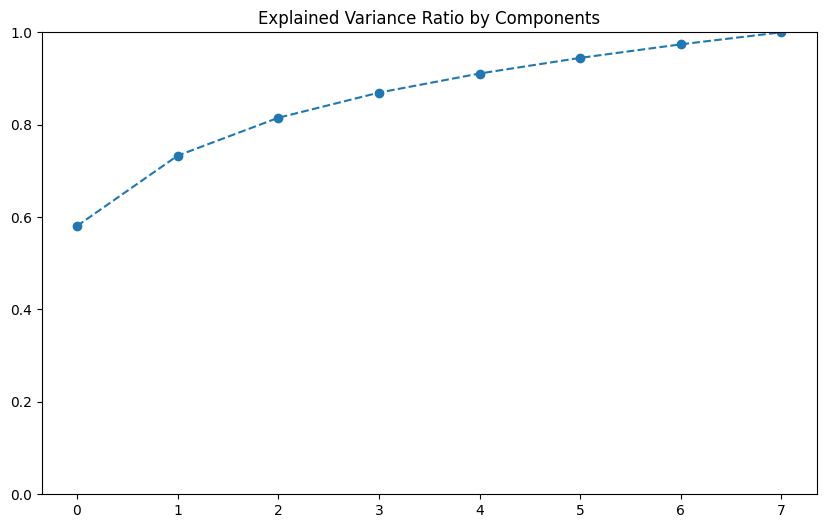

In [137]:
# plot that as scree plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(full_pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')

plt.ylim(0, 1)

plt.title('Explained Variance Ratio by Components')

In [138]:
full_pca_data.shape

(34214400, 8)

In [139]:
middle_vectors_full_pca, _ = extract_middle_vectors(torch.Tensor(full_pca_data))

middle_vectors_full_pca.shape

torch.Size([2365, 8])

# Cluster

### Function Definitions 📚

In [11]:
import pandas as pd
import dask.dataframe as dd
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Define the organs dictionary
organs_dict = {
    'background/unlabeled': 0,  # For multi-class use case
    'aorta': 1,
    'gall_bladder': 2,
    'spleen': 3,
    'stomach': 4,
    'kidney_right': 5,
    'kidney_left': 6,
    'liver': 7,
    'pancreas': 8,
    'postcava': 9
}

# Define a fixed label order
label_order = [
    'background/unlabeled',
    'aorta',
    'gall_bladder',
    'spleen',
    'stomach',
    'kidney_right',
    'kidney_left',
    'liver',
    'pancreas',
    'postcava'
]

# Create a reverse mapping from label numbers to organ names
reverse_organs_dict = {v: k for k, v in organs_dict.items()}

def calculate_purities(data, labels, algorithms, plot=True, normalize_bars=True):
    # Define binary label mapping
    binary_label_mapping = {0: 'background/unlabeled', 1: 'pancreas'}

    # Determine the label mapping
    unique_labels = sorted(pd.unique(labels))
    if unique_labels == [0, 1]:
        label_mapping = binary_label_mapping
    else:
        label_mapping = reverse_organs_dict

    results = []

    # Clustering and purity calculation
    for name, estimator in tqdm(algorithms, desc="Clustering Algorithms", unit="alg"):
        estimator.fit(data)
        if hasattr(estimator, 'labels_'):
            cluster_labels = estimator.labels_
        elif hasattr(estimator, 'predict'):
            cluster_labels = estimator.predict(data)
        else:
            raise AttributeError(f"The estimator {name} does not have 'labels_' or 'predict' method.")

        df = pd.DataFrame(data, columns=[f'Feature_{i+1}' for i in range(data.shape[1])])
        df = df.reset_index(drop=True)
        df['Cluster'] = cluster_labels
        df['Labels'] = labels

        df_dd = dd.from_pandas(df, npartitions=4)
        df_dd['Cluster'] = df_dd['Cluster'].astype('category')
        df_dd['Labels'] = df_dd['Labels'].astype('category')
        df_dd = df_dd.persist()

        counts = df_dd.groupby(['Cluster', 'Labels']).size()
        counts_pd = counts.compute()
        cluster_label_counts = counts_pd.unstack(fill_value=0)
        cluster_label_ratio = cluster_label_counts.div(cluster_label_counts.sum(axis=1), axis=0)

        # Calculate total points per cluster
        cluster_sizes = cluster_label_counts.sum(axis=1)

        # Keep counts and ratios with prefixes to avoid naming conflicts
        count_cols = [f"Count_{label_mapping.get(col, col)}" for col in cluster_label_counts.columns]
        ratio_cols = [f"Ratio_{label_mapping.get(col, col)}" for col in cluster_label_ratio.columns]

        cluster_label_counts.columns = count_cols
        cluster_label_ratio.columns = ratio_cols

        purity_df = pd.concat([cluster_label_counts, cluster_label_ratio], axis=1).reset_index()
        purity_df['Algorithm'] = name

        if hasattr(estimator, 'n_clusters'):
            purity_df['n_clusters'] = estimator.n_clusters
        else:
            purity_df['n_clusters'] = None

        # Add cluster sizes to the DataFrame
        purity_df['Cluster_Size'] = cluster_sizes.values

        results.append(purity_df)

    final_df = pd.concat(results, ignore_index=True)

    # Plotting
    if plot:
        # Plotting the stacked bar chart
        for algo in final_df['Algorithm'].unique():
            algo_df = final_df[final_df['Algorithm'] == algo].copy()
            algo_df.set_index('Cluster', inplace=True)

            # Ensure the 'Cluster' index is of integer type and sorted
            algo_df.index = algo_df.index.astype(int)
            algo_df.sort_index(inplace=True)

            # Identify ratio and count columns
            ratio_cols = [col for col in algo_df.columns if col.startswith('Ratio_')]
            count_cols = [col for col in algo_df.columns if col.startswith('Count_')]

            # Get labels
            ratio_labels = [col.replace('Ratio_', '') for col in ratio_cols]
            count_labels = [col.replace('Count_', '') for col in count_cols]

            # Create mapping from labels to columns
            ratio_col_map = dict(zip(ratio_labels, ratio_cols))
            count_col_map = dict(zip(count_labels, count_cols))

            # Ensure labels are in consistent order
            labels_in_data = [label for label in label_order if label in ratio_labels or label in count_labels]

            if normalize_bars:
                # Use purity ratios for plotting (bars of height 1)
                columns_to_plot = [ratio_col_map[label] for label in labels_in_data]
                algo_df_plot = algo_df[columns_to_plot]
            else:
                # Use counts for plotting (bars of varying heights based on cluster sizes)
                columns_to_plot = [count_col_map[label] for label in labels_in_data]
                algo_df_plot = algo_df[columns_to_plot]

            # Rename columns to labels for plotting
            algo_df_plot.columns = labels_in_data

            # Generate colors based on the fixed label order
            n_labels_total = len(label_order)
            colors_palette = sns.color_palette("tab10", n_labels_total)
            label_to_color = dict(zip(label_order, colors_palette))
            colors = [label_to_color[label] for label in labels_in_data]

            # Plotting the stacked bar chart
            fig, ax = plt.subplots(figsize=(12, 8))

            algo_df_plot.plot(
                kind='bar',
                stacked=True,
                edgecolor='black',
                color=colors,
                ax=ax
            )

            # Adding labels and title
            ax.set_xlabel('Cluster', fontsize=14)
            y_label = 'Purity Ratio' if normalize_bars else 'Number of Points'
            ax.set_ylabel(y_label, fontsize=14)
            title_suffix = ' (Normalized)' if normalize_bars else ' (By Cluster Size)'
            ax.set_title(f'Purity Ratios per Cluster for {algo}{title_suffix}', fontsize=16)

            # Adding cluster size annotations above each bar
            for idx, row in enumerate(algo_df.itertuples()):
                total_height = algo_df_plot.iloc[idx].sum()
                ax.text(
                    idx,
                    total_height + ax.get_ylim()[1]*0.01,
                    f"{int(row.Cluster_Size):,}",
                    ha='center',
                    va='bottom',
                    fontsize=10,
                    rotation=90
                )

            # Adjusting legend
            handles, labels_ = ax.get_legend_handles_labels()
            ax.legend(handles, labels_in_data, title='Labels', bbox_to_anchor=(1.05, 1), loc='upper left')

            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.show()

            algo_df.reset_index(inplace=True)

    return final_df

def cluster_and_plot_purities(data, labels, cluster_range=range(2, 51, 2), plot=True, random_state=42, normalize_bars=True):
    import warnings

    warnings.filterwarnings(
        "ignore",
        category=FutureWarning,
        message="The default of observed=False is deprecated and will be changed to True in a future version of pandas."
    )

    algorithms = []

    for n_clusters in cluster_range:
        mbk_name = f'MiniBatchKMeans_n{n_clusters}'
        mbk = MiniBatchKMeans(
            n_clusters=n_clusters,
            random_state=random_state,
            batch_size=10000,
            init='k-means++',
            n_init='auto'
        )
        algorithms.append((mbk_name, mbk))

    purity_results = calculate_purities(
        data=data,
        labels=labels,
        algorithms=algorithms,
        plot=plot,
        normalize_bars=normalize_bars
    )

    return purity_results, algorithms

import matplotlib.pyplot as plt
import pandas as pd

def plot_prior_distribution(labels, label_mapping=reverse_organs_dict):
    """
    Plot the prior distribution of the original labels as a bar chart.

    Parameters:
    - labels: array-like, shape (n_samples,)
        The true labels.
    - label_mapping: dict, optional
        Dictionary mapping label numbers to organ names.
    """
    # Calculate the label distribution (counts and proportions)
    label_counts = pd.Series(labels).value_counts().sort_index()
    label_proportions = label_counts / label_counts.sum()

    # If a label mapping is provided, replace label numbers with organ names
    if label_mapping:
        label_names = [label_mapping.get(lbl, lbl) for lbl in label_counts.index]
    else:
        label_names = [k for k, v in sorted(organs_dict.items(), key=lambda item: item[1])]

    # Create a DataFrame for plotting
    label_df = pd.DataFrame({
        'Label': label_names,
        'Count': label_counts.values,
        'Proportion': label_proportions.values
    })

    # Plotting the bar chart for the prior distribution
    fig, ax = plt.subplots(figsize=(10, 6))

    # Generate colors based on the fixed label order
    n_labels_total = len(label_order)
    colors_palette = sns.color_palette("tab10", n_labels_total)
    label_to_color = dict(zip(label_order, colors_palette))
    colors = [label_to_color.get(label, 'grey') for label in label_df['Label']]

    ax.bar(label_df['Label'], label_df['Proportion'], color=colors, edgecolor='black')

    # Adding labels and title
    ax.set_xlabel('Organ', fontsize=14)
    ax.set_ylabel('Proportion', fontsize=14)
    ax.set_title('Prior Distribution of Organ Labels', fontsize=16)

    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.tight_layout()
    plt.show()

In [12]:
# Put your best clustering algorithm here

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import OPTICS, DBSCAN


minibatchkmeans_10 = MiniBatchKMeans(n_clusters=10, random_state=42)
minibatchkmeans_6 = MiniBatchKMeans(n_clusters=6, random_state=42)
minibatchkmeans_2 = MiniBatchKMeans(n_clusters=2, random_state=42)
minibatchkmeans_4 = MiniBatchKMeans(n_clusters=4, random_state=42)
minibatchkmeans_8 = MiniBatchKMeans(n_clusters=8, random_state=42)
minibatchkmeans_12 = MiniBatchKMeans(n_clusters=12, random_state=42)
minibatchkmeans_14 = MiniBatchKMeans(n_clusters=14, random_state=42)

optics = OPTICS()
dbscan = DBSCAN()

## Full Raw Data, Tissue Density Labels

In [14]:
flat_enc_cts = flatten_features(all_encoded_cubes)

In [15]:
tissue_density_labels = torch.load('data/generated-data/tissue_density_labels.pt')

### TODO issue with tissue_density_labels - it was not encoded so now it's too big. Fix this later

In [16]:
tissue_density_labels.shape

torch.Size([44, 55, 96, 96, 96])

In [17]:
sampled_points_coordinates.shape

torch.Size([44, 55, 3])

In [18]:
data = flat_enc_cts.numpy()
labels = tissue_density_labels.flatten().numpy()

In [19]:
minibatchkmeans_10.fit(data)

/home/alubonj1/scr4_randalburns/DiffTumor/venv-py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


MiniBatchKMeans(n_clusters=10, random_state=42)

In [21]:
data.shape

(33454080, 8)

In [22]:
labels.shape

(2141061120,)

In [20]:
cluster_and_plot_purities(data, labels)

Clustering Algorithms:   0%|          | 0/49 [00:03<?, ?alg/s]


ValueError: Length of values (2141061120) does not match length of index (33454080)

## Middle Vectors of $24^3$, Multi-Organ Labels Purities

Raw data, no scaling, no PCA. Just Flattened

In [182]:
flat_enc_cts = flatten_features(all_encoded_cubes)
raw_cubes_middle_vecs, _ = extract_middle_vectors(flat_enc_cts)#.unsqueeze(0))#(0))[0]

In [183]:
raw_cubes_middle_vecs.shape

torch.Size([2365, 8])

In [184]:
data = raw_cubes_middle_vecs.numpy()

In [185]:
labels = sampled_points_multi_organ_labels.flatten().numpy()

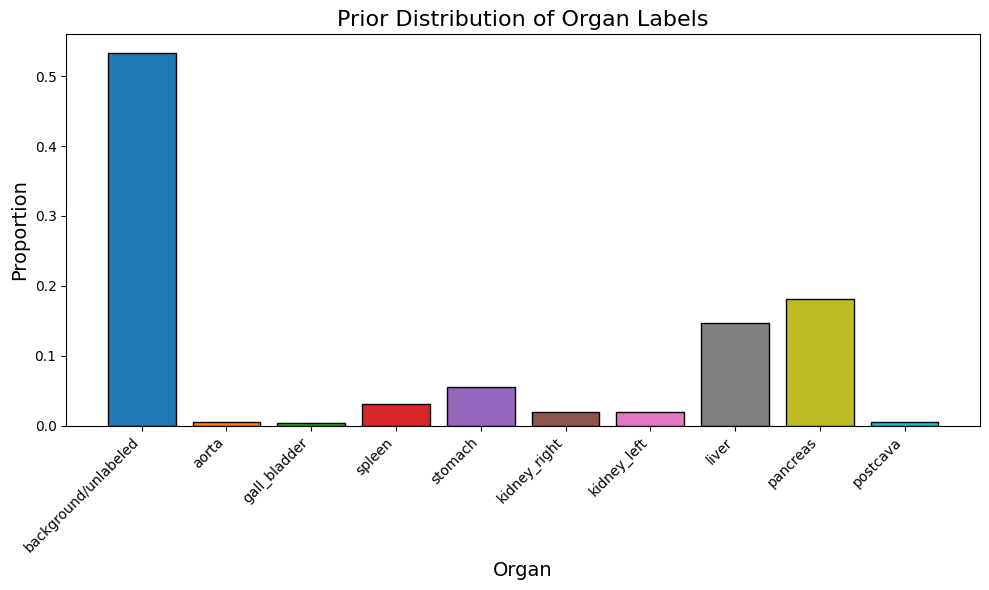

In [186]:
plot_prior_distribution(sampled_points_multi_organ_labels.flatten().numpy())#, label_mapping=reverse_organs_dict)

Clustering Algorithms: 100%|██████████| 25/25 [00:18<00:00,  1.34alg/s]


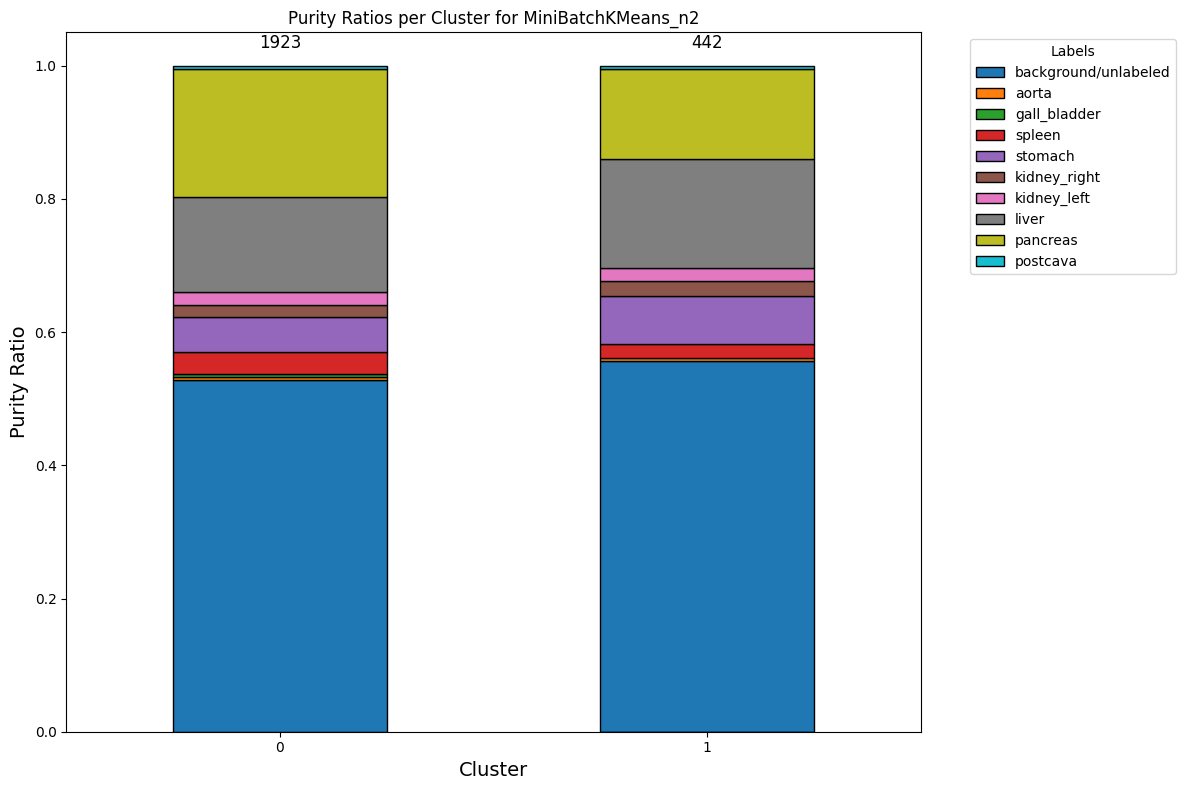

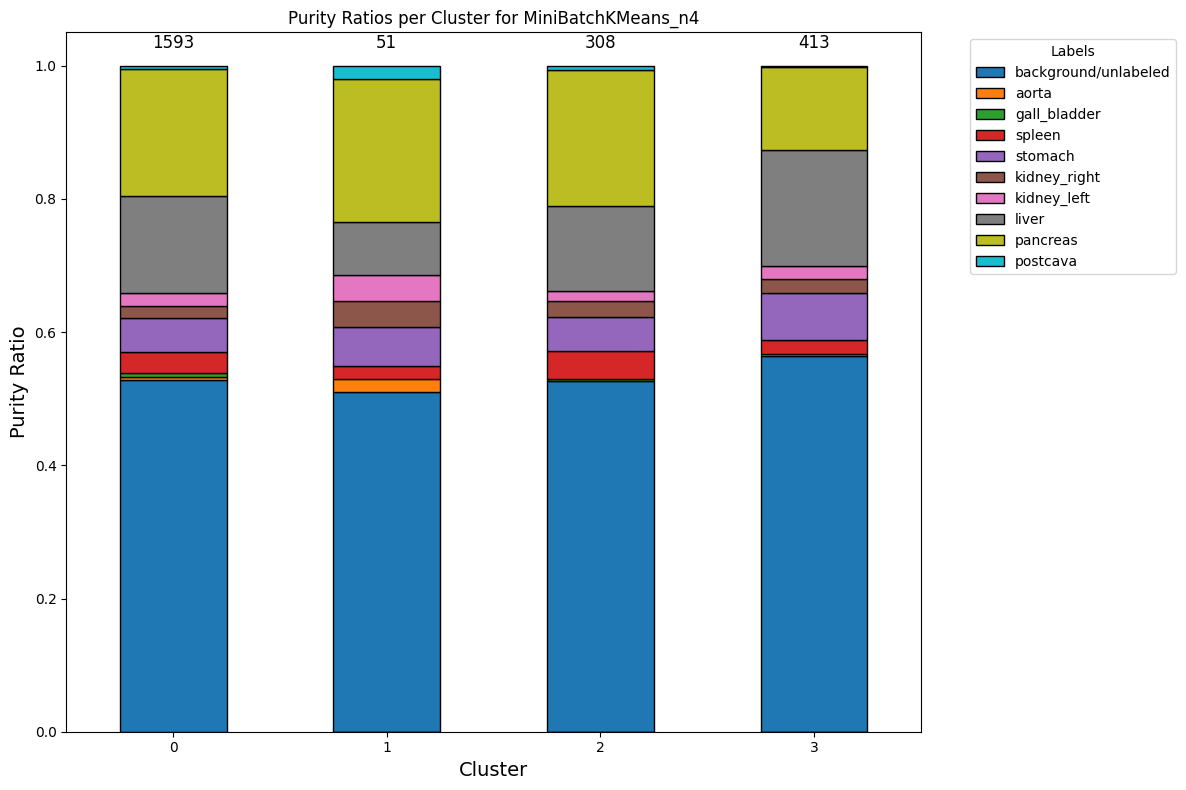

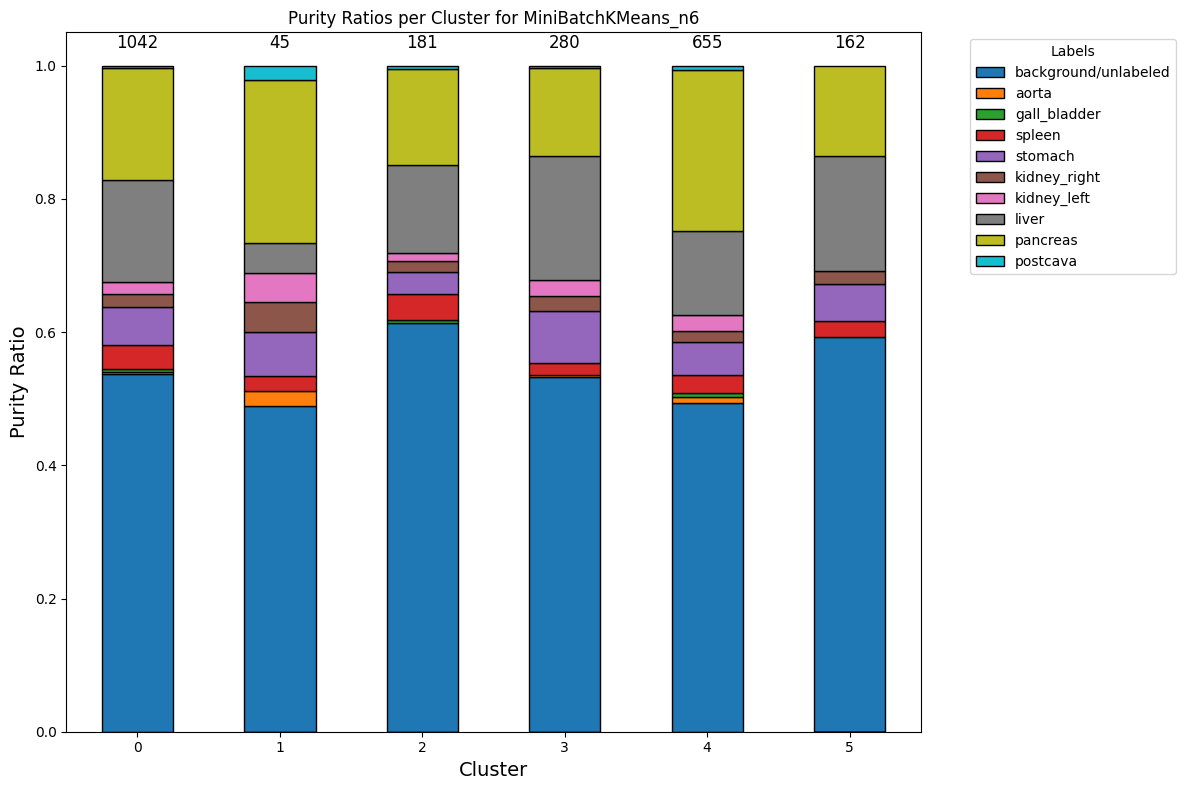

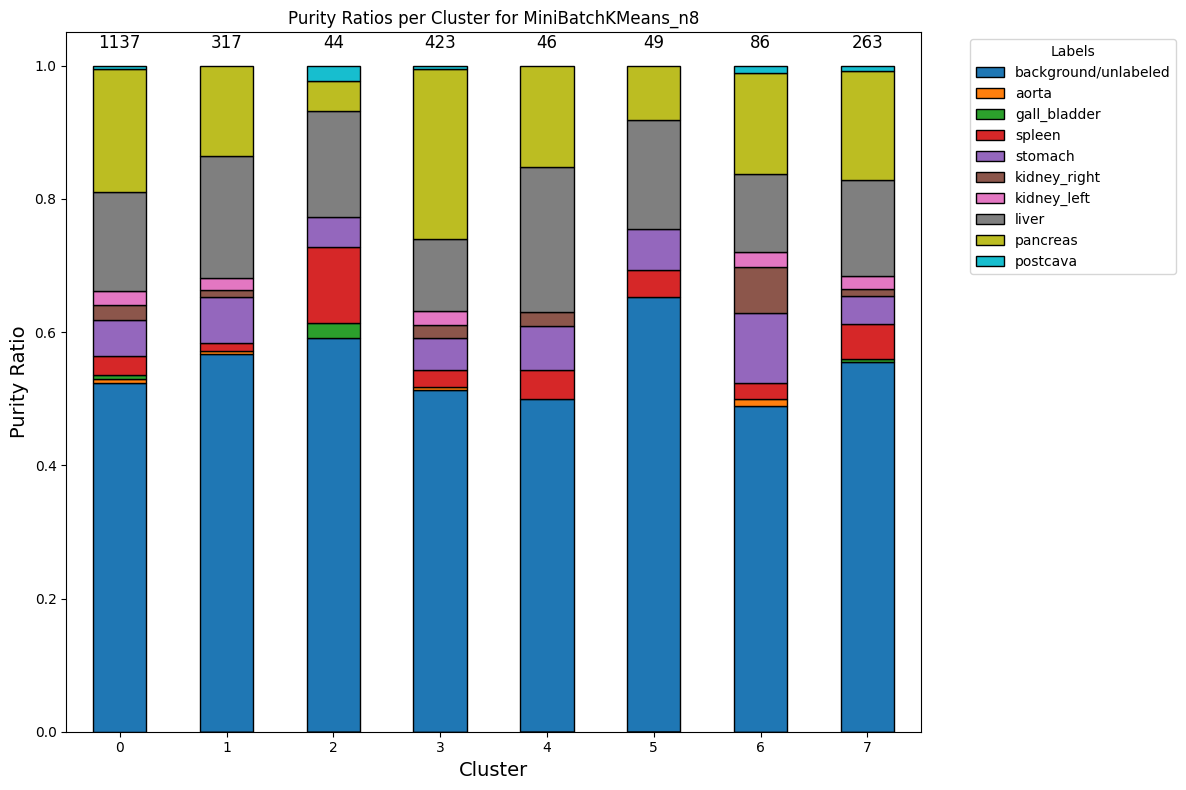

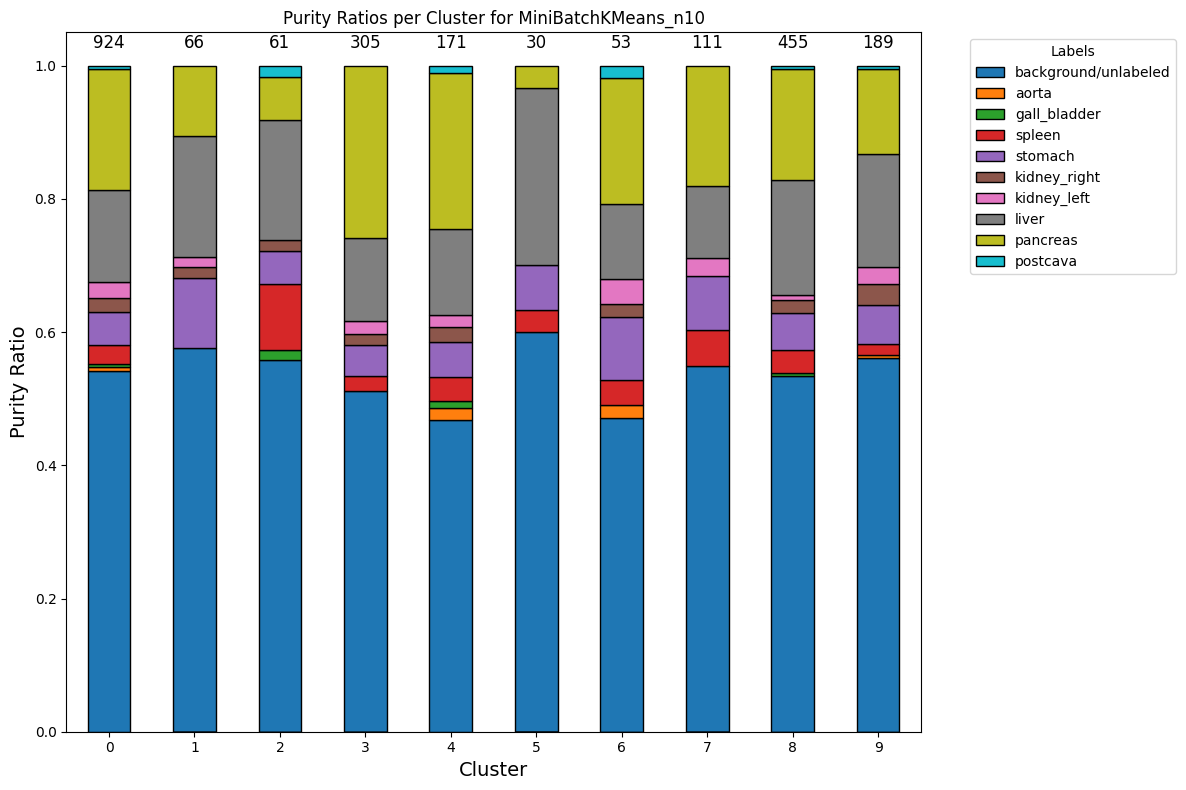

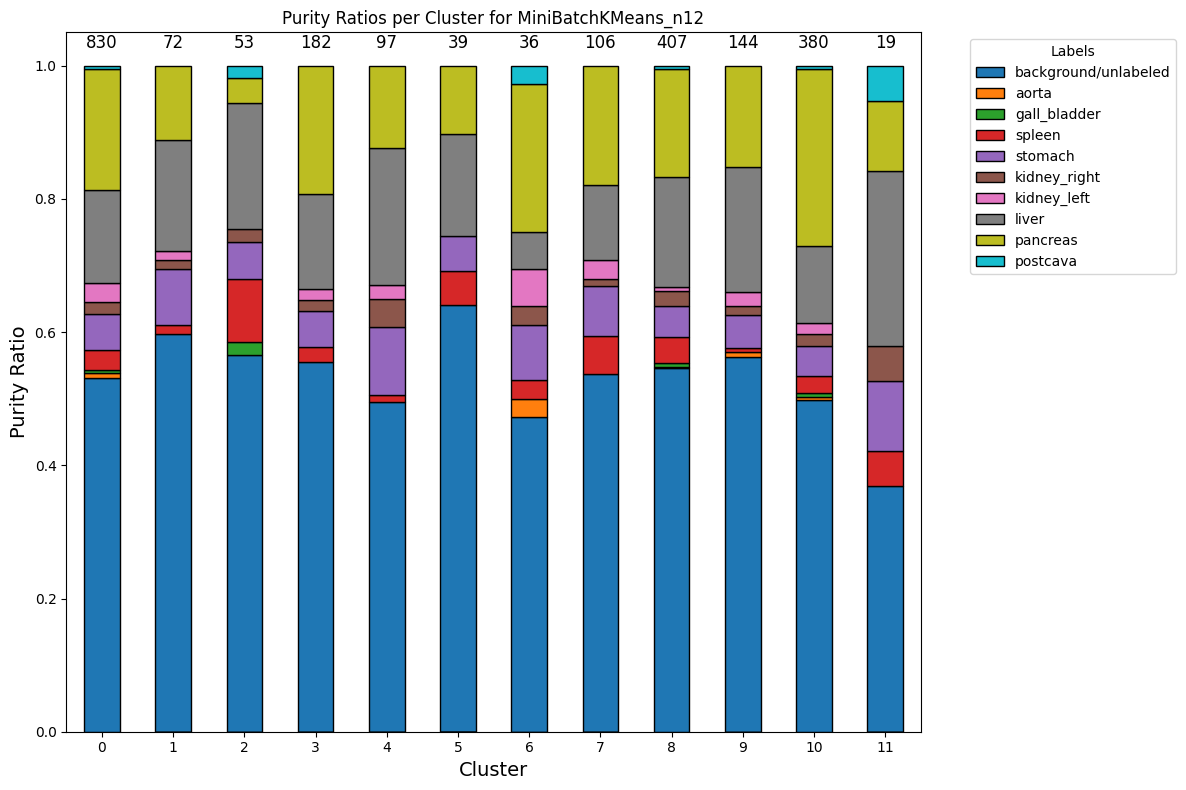

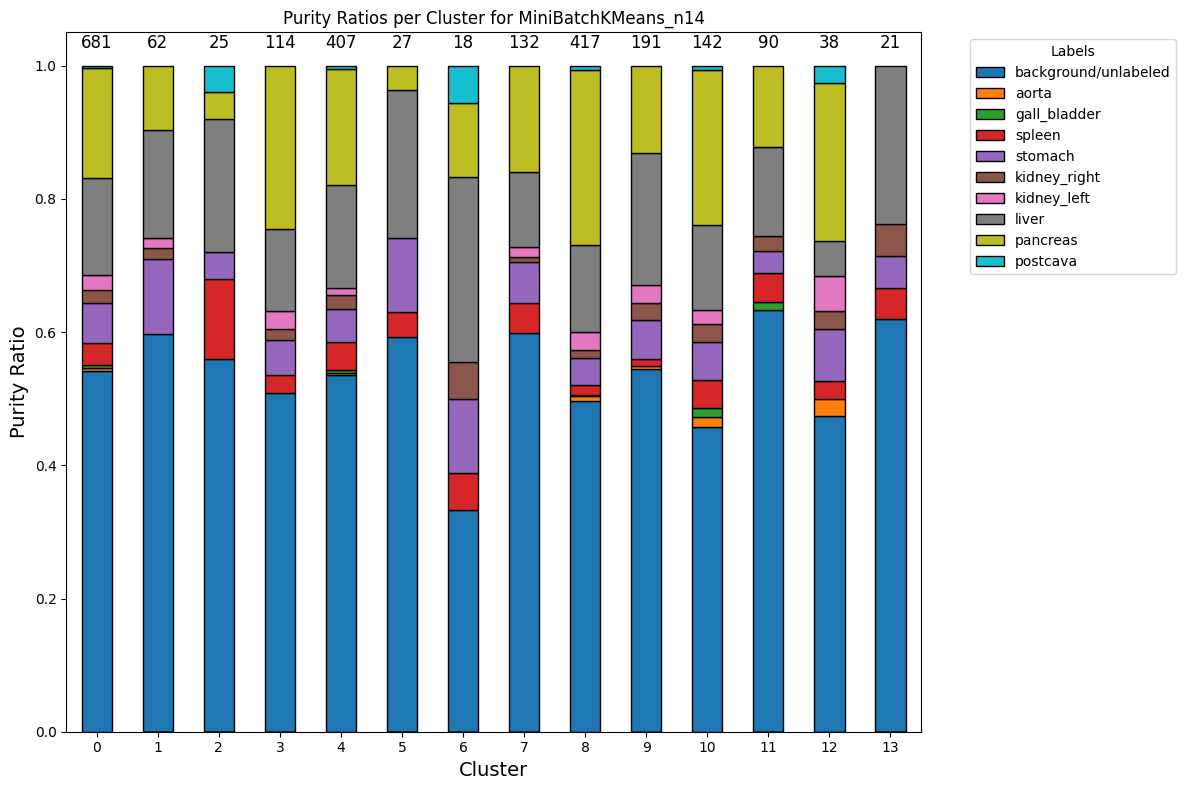

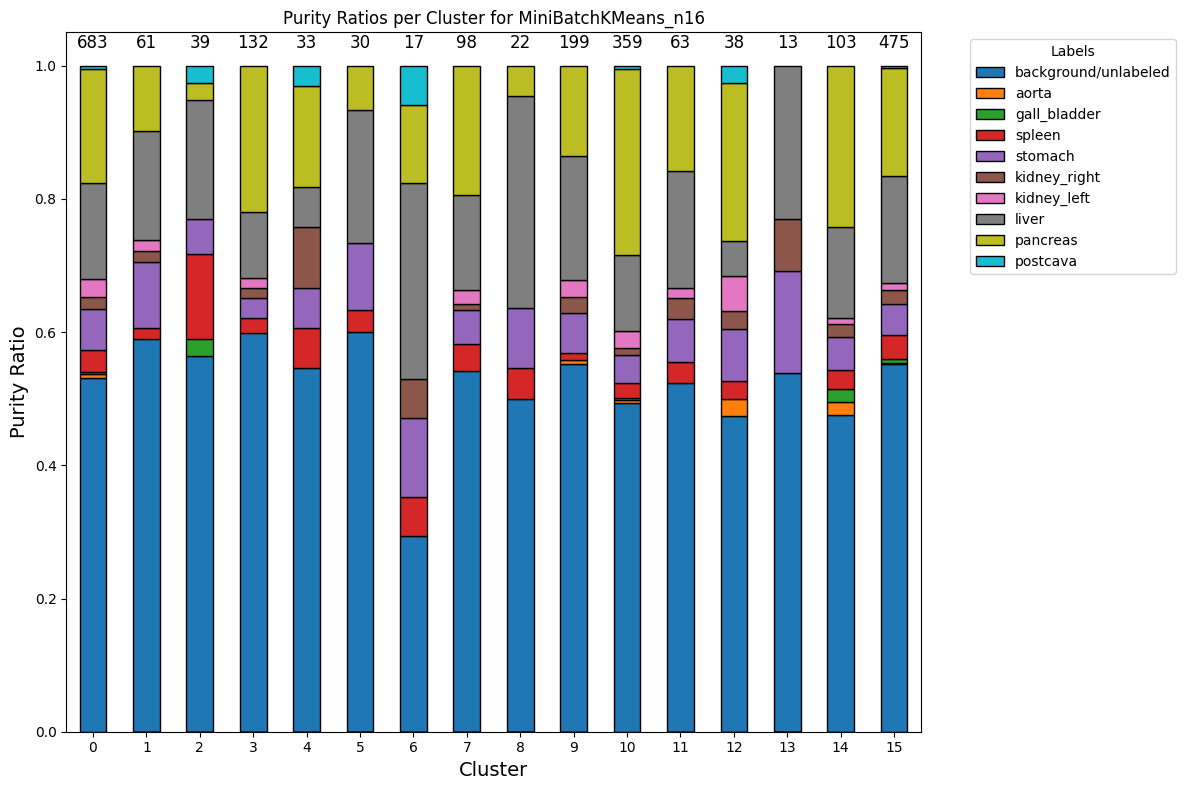

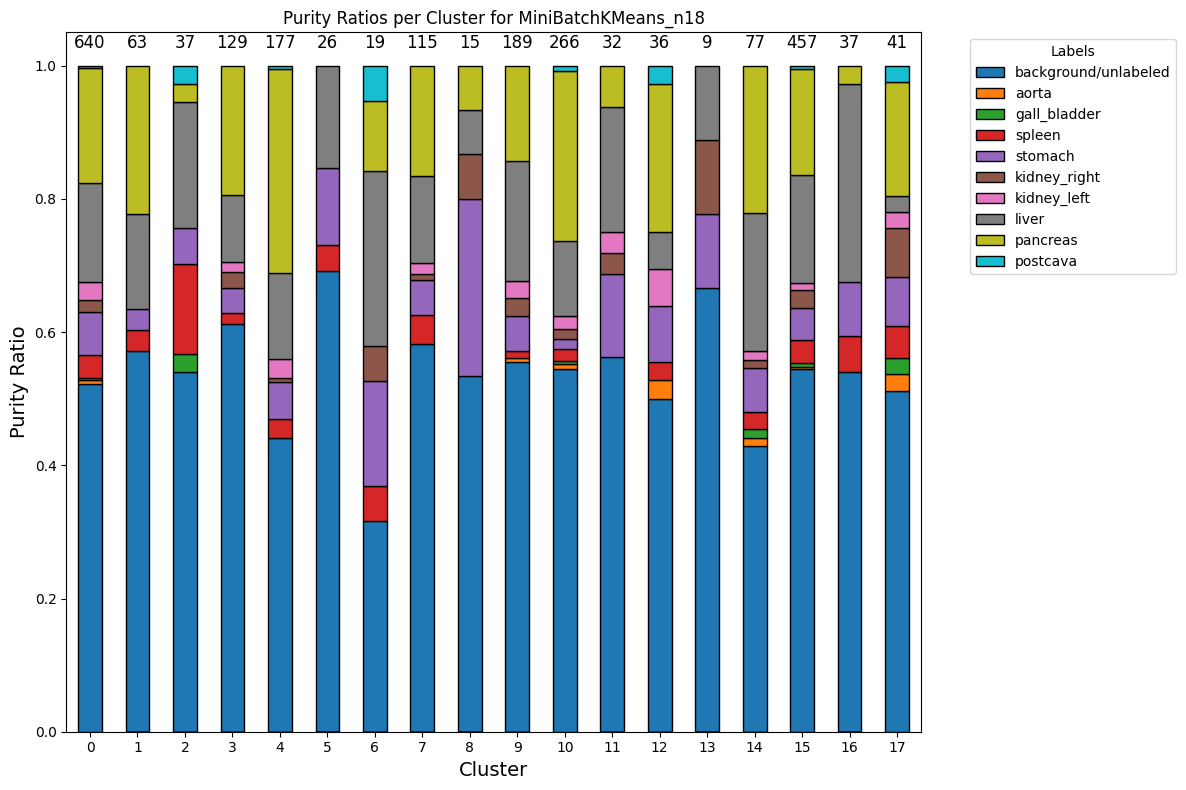

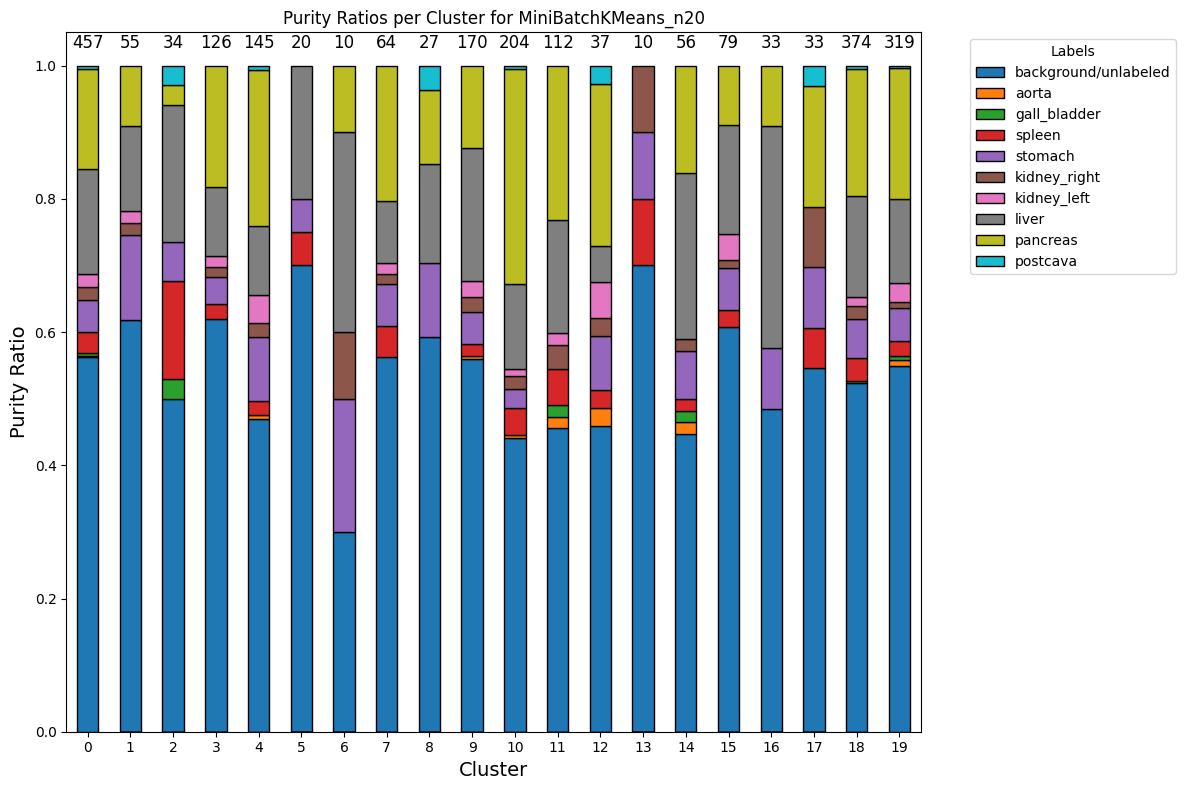

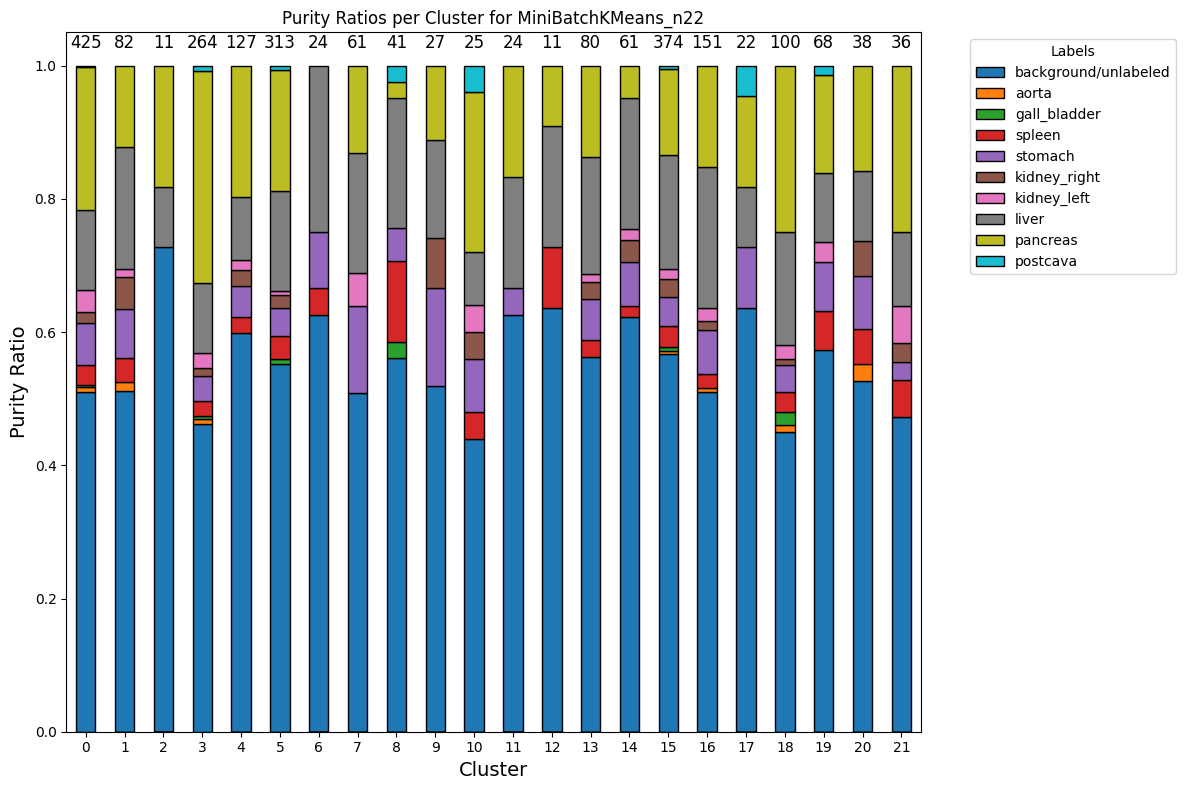

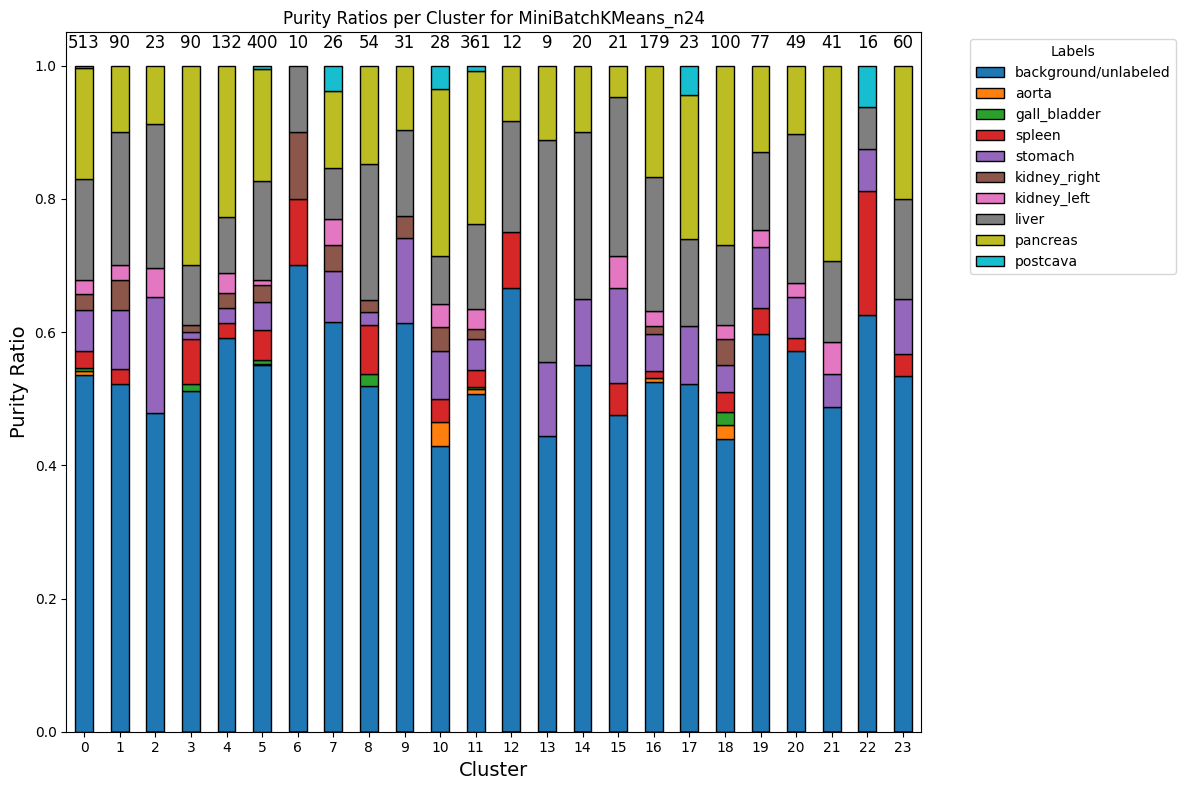

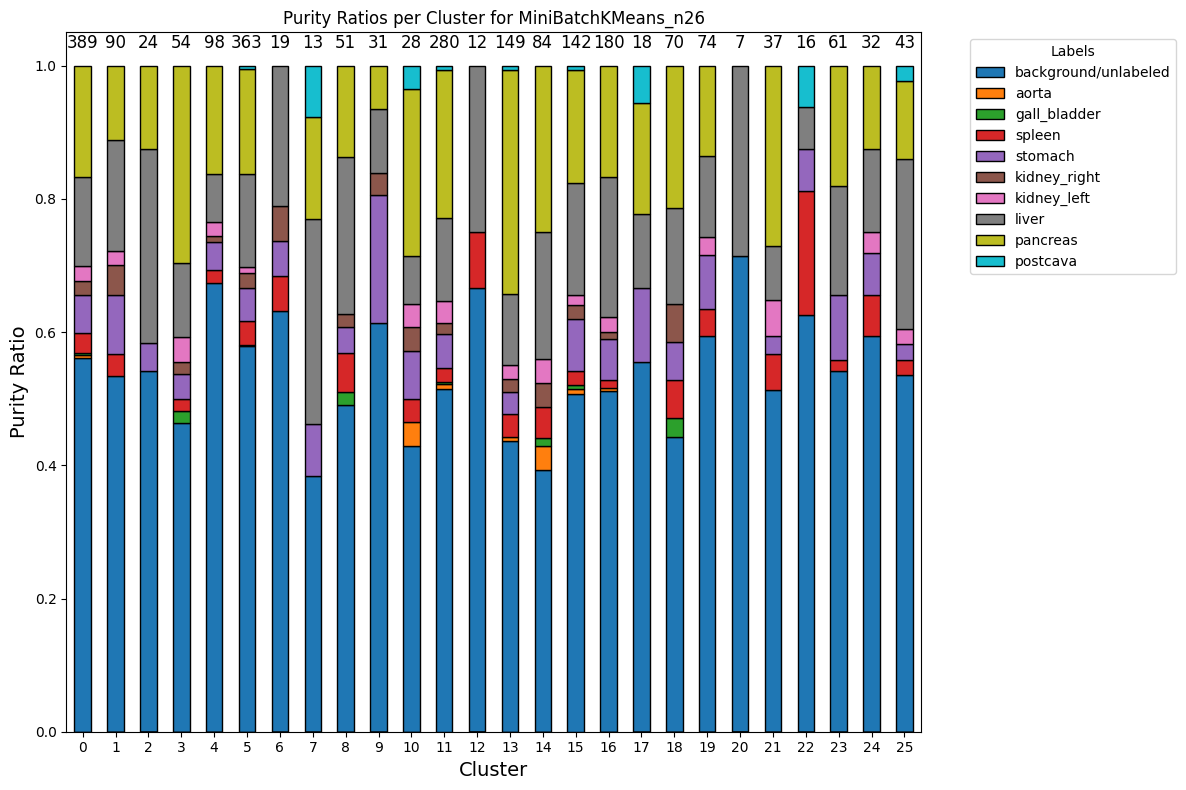

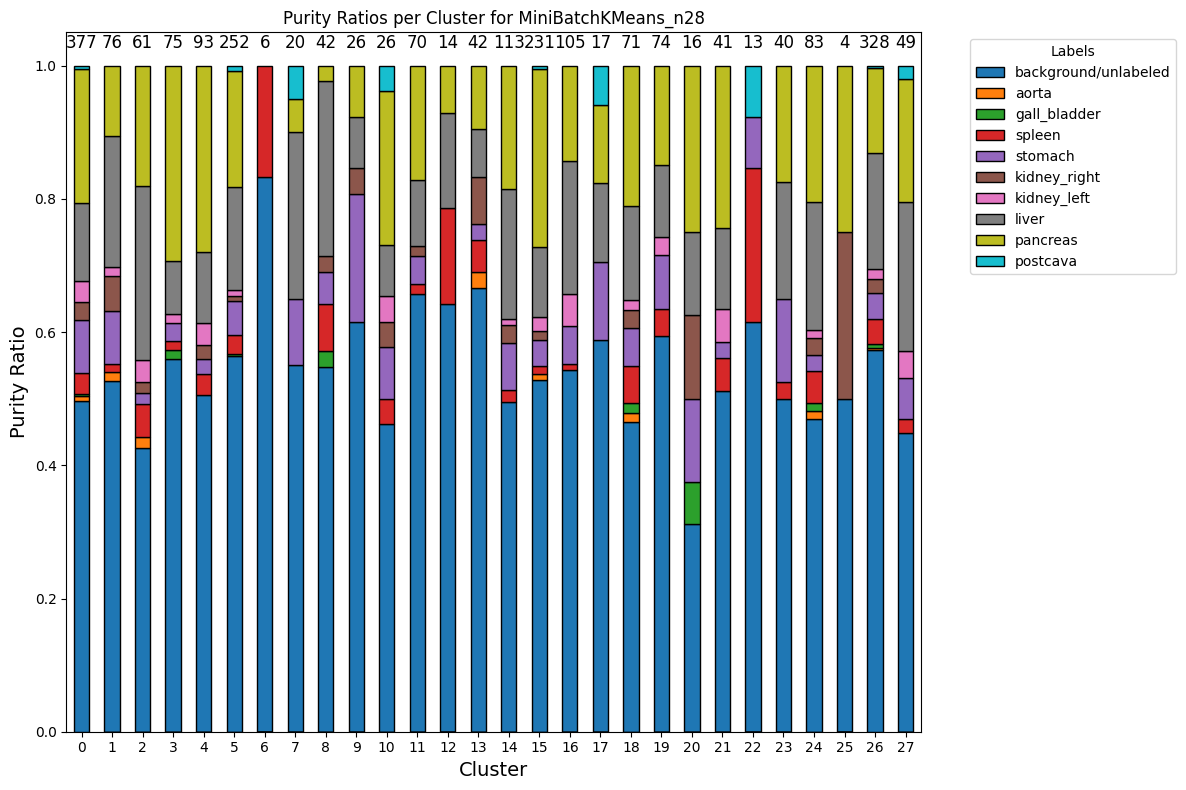

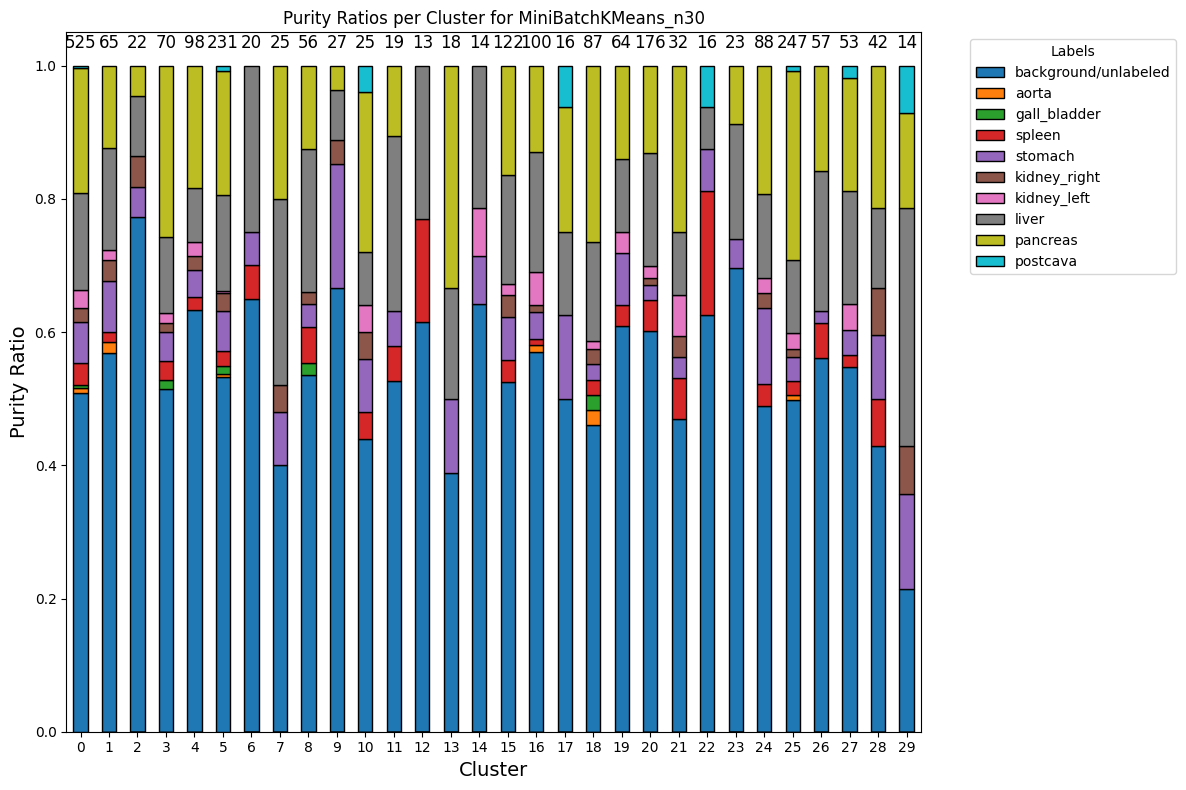

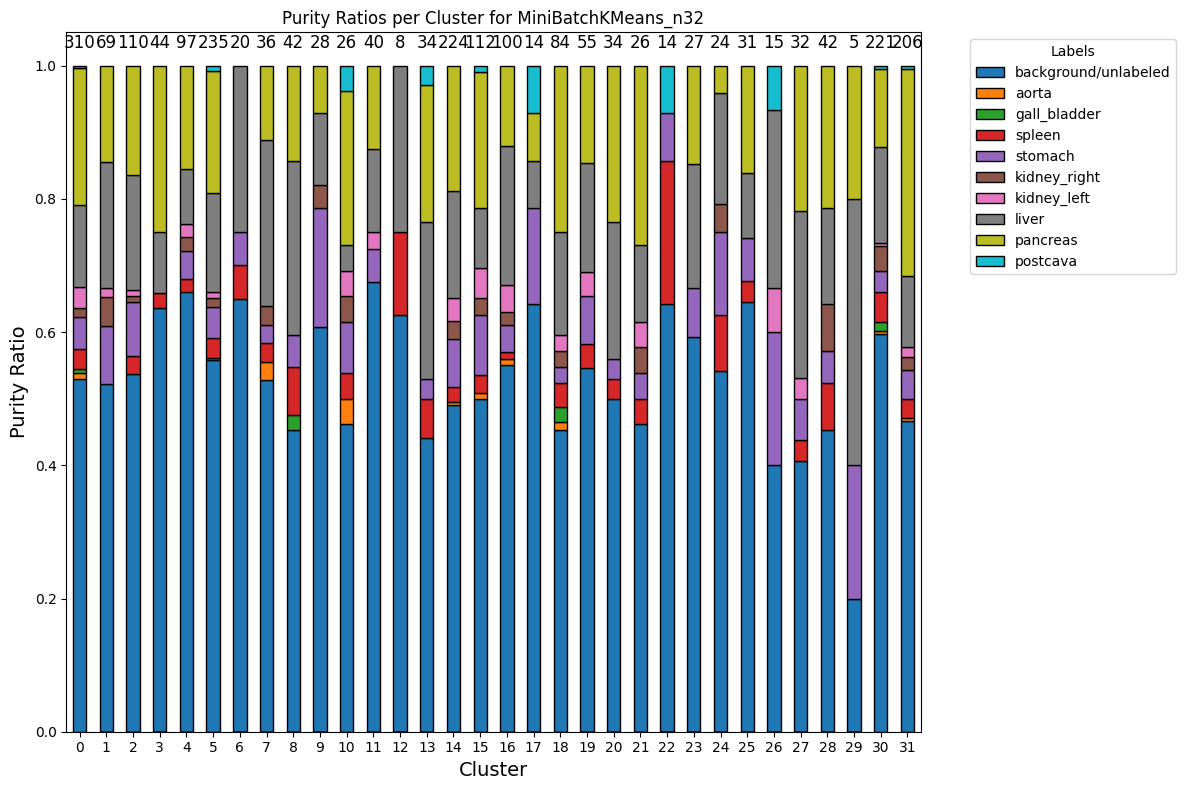

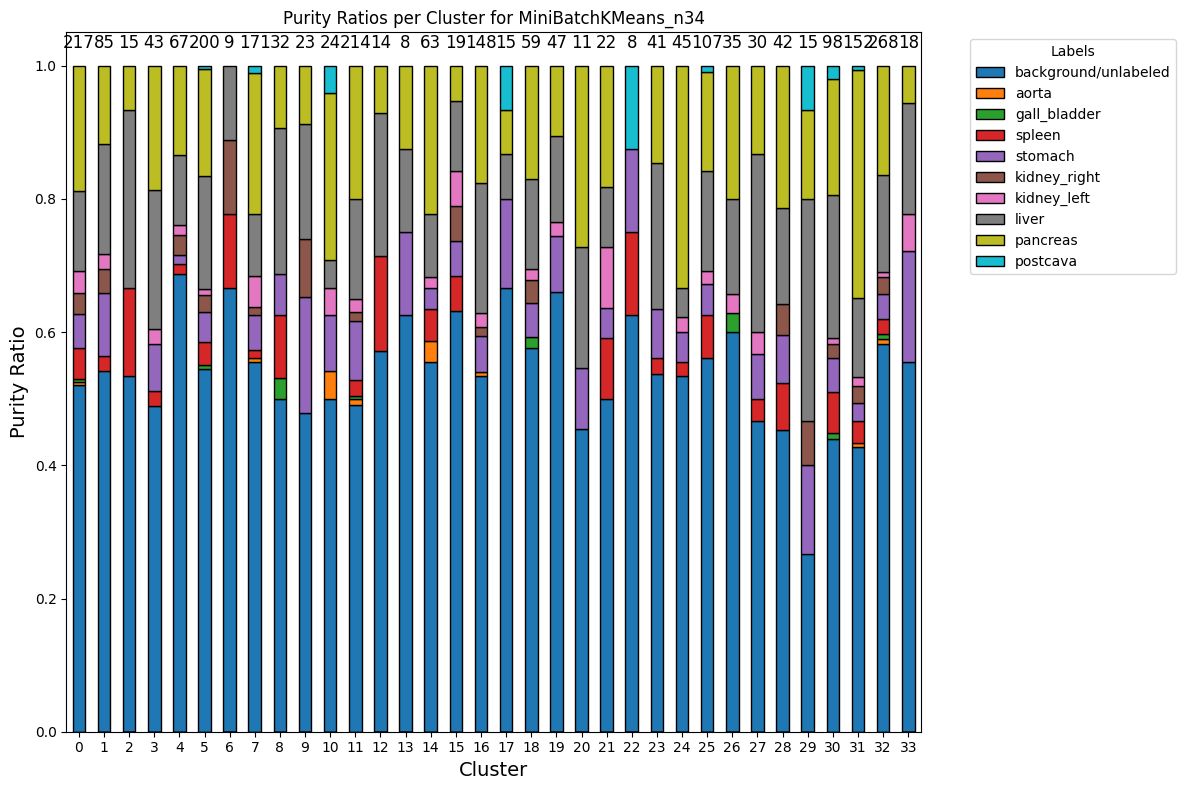

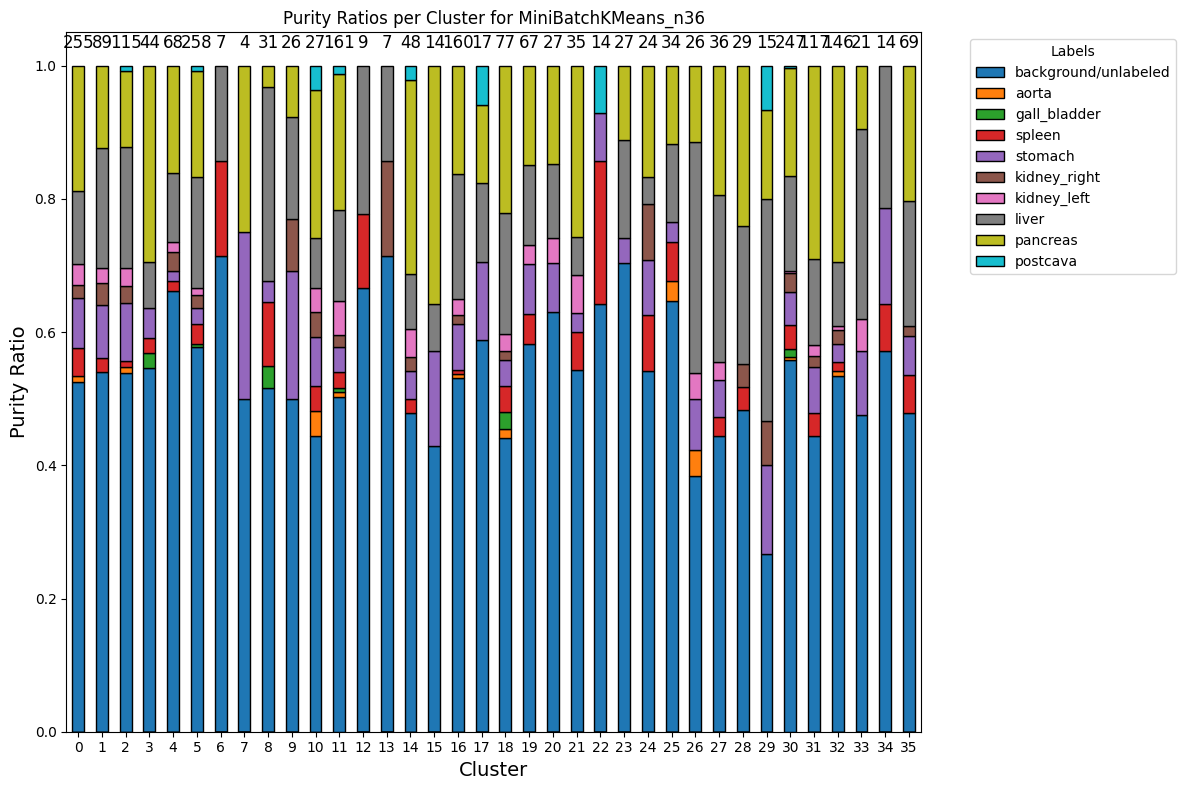

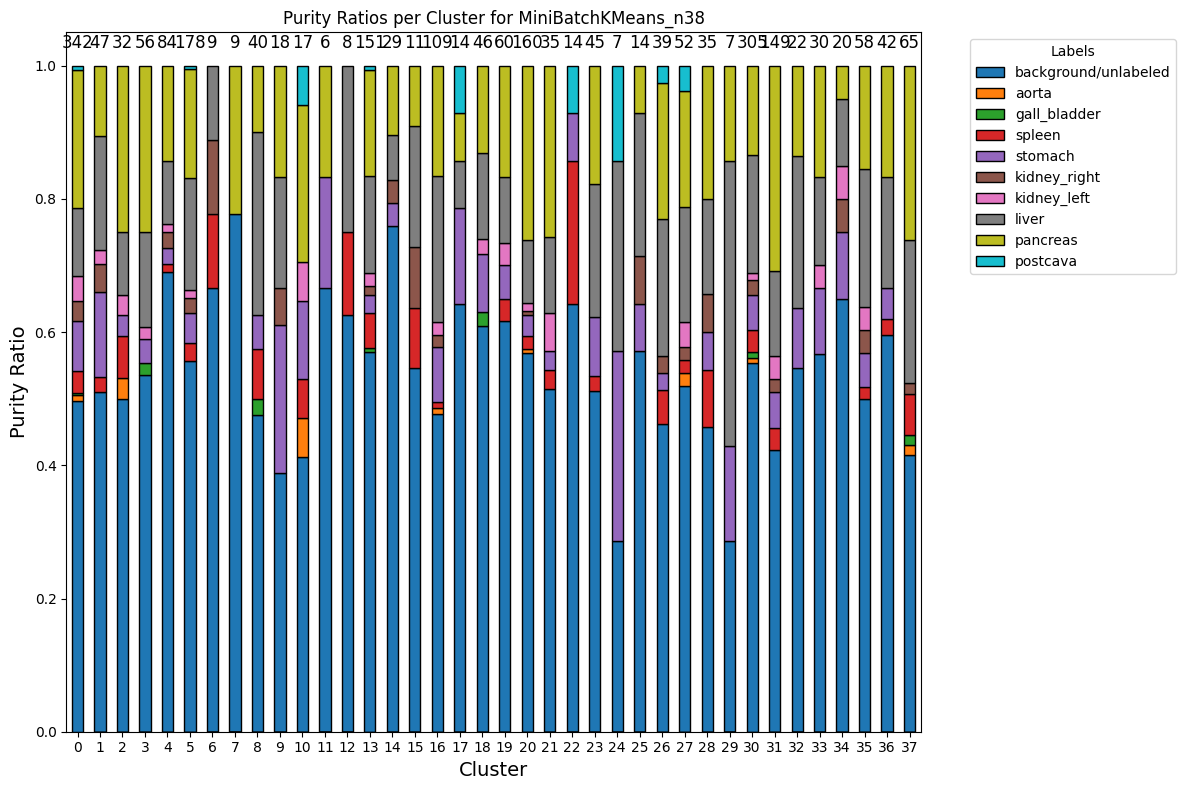

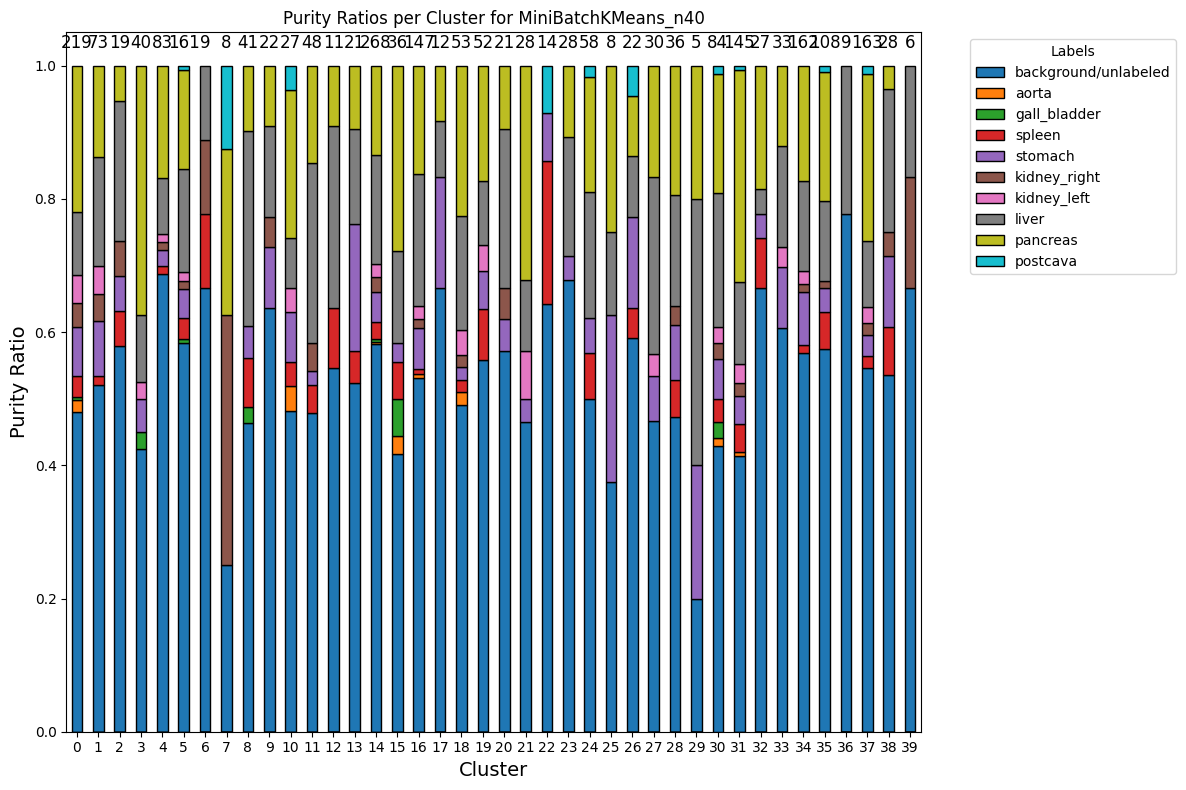

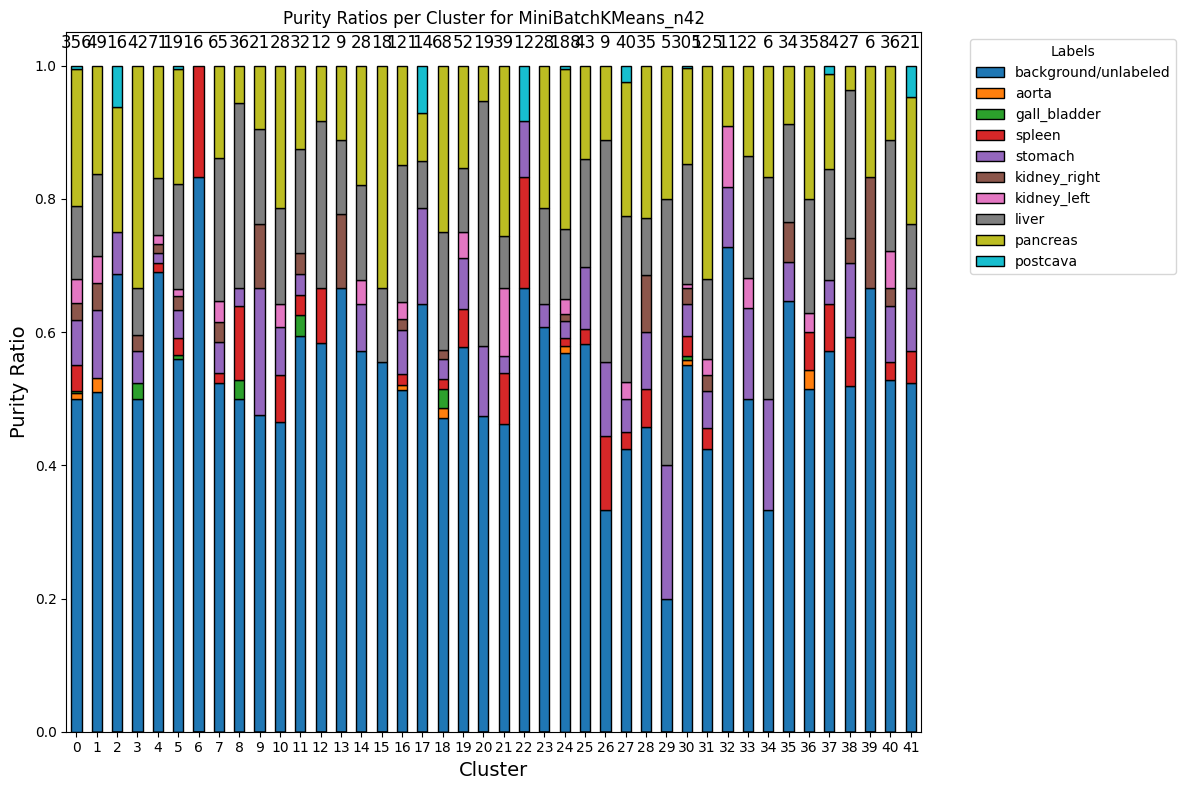

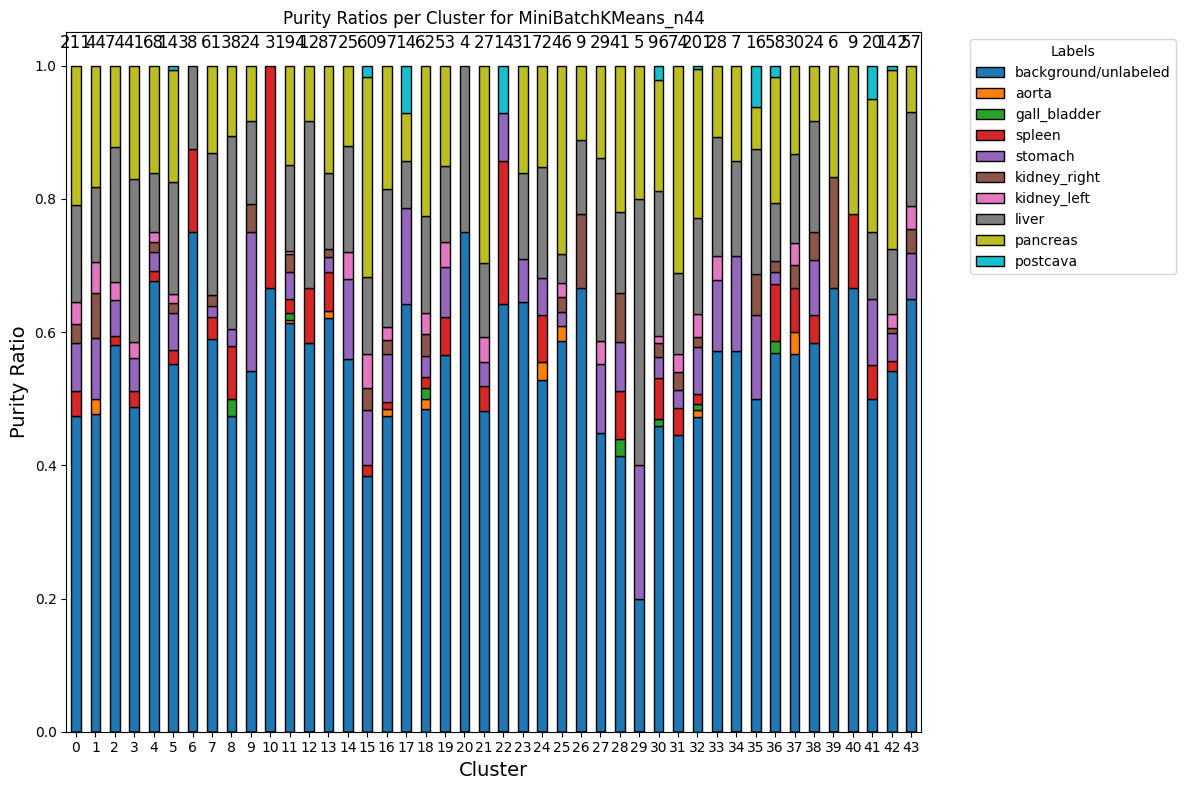

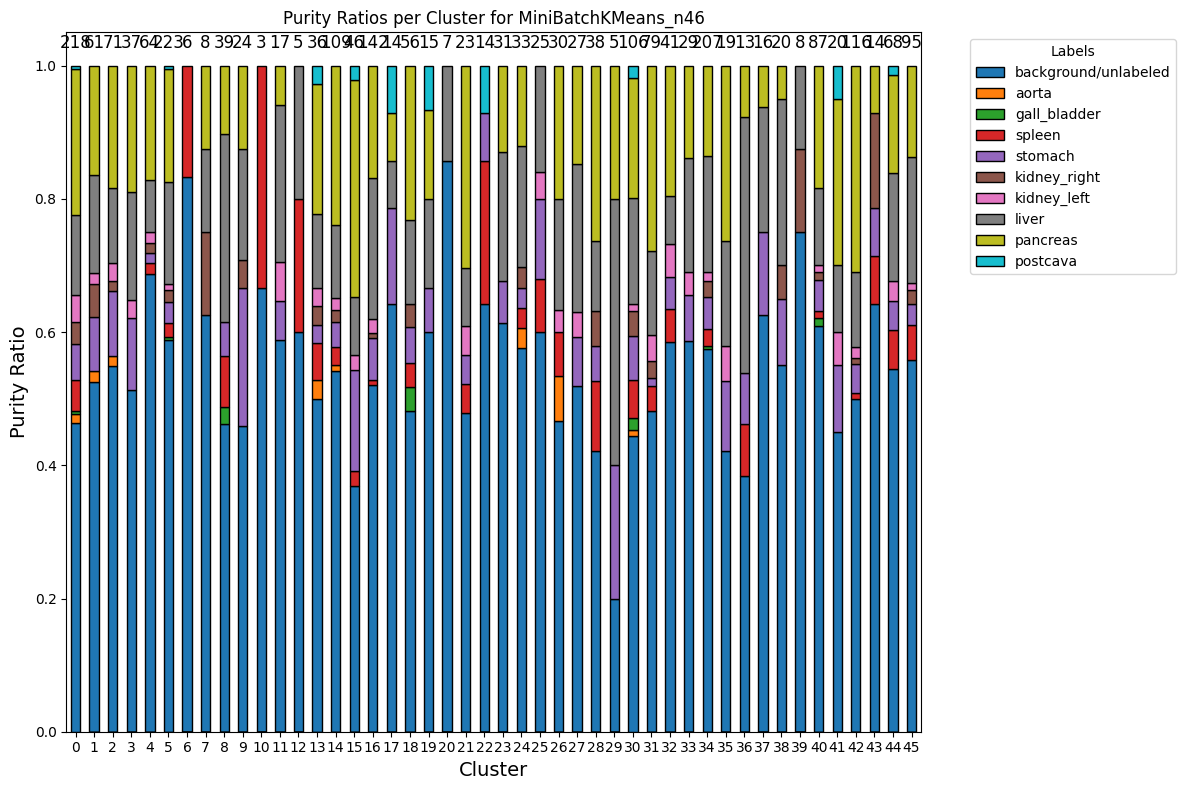

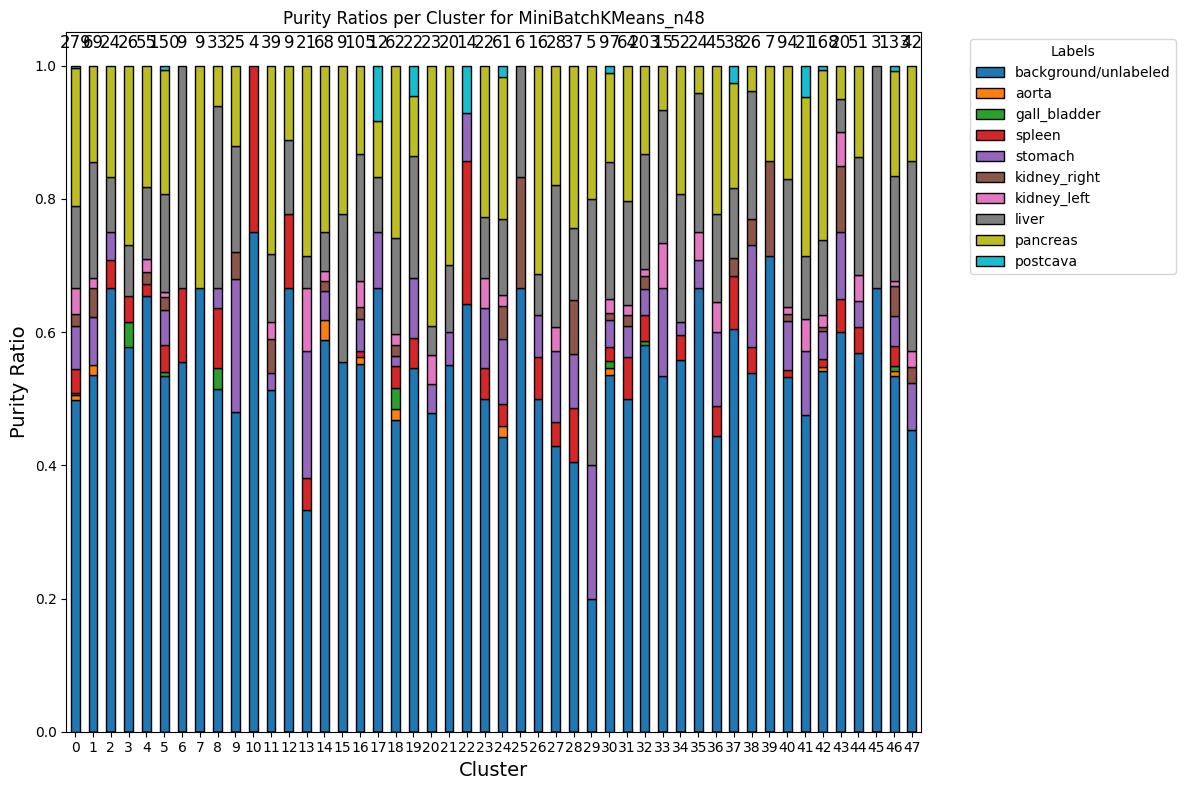

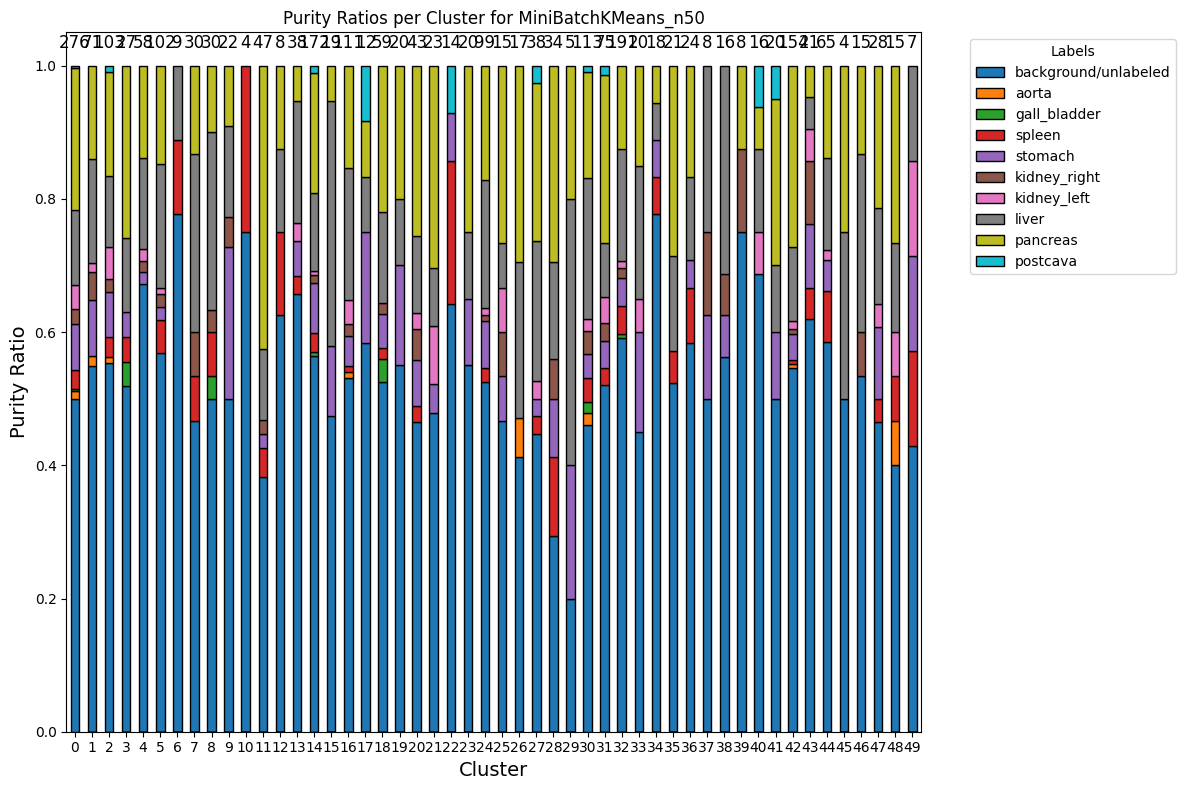

In [187]:
cluster_results, algorithms = cluster_and_plot_purities(data, labels)#, use_case='multi-class')

## Random State Sampled Points interesting clustering results

Random state 1
2 also (Last column in clustering - clusters 29,49)
3
4
5


## Analyzing Clusters

`random_state=50`, cluster #49

In [13]:
kmeans_random_state = 1

In [14]:
flat_enc_cts = flatten_features(all_encoded_cubes)
raw_cubes_middle_vecs, _ = extract_middle_vectors(flat_enc_cts)#.unsqueeze(0))#(0))[0]

data = raw_cubes_middle_vecs.numpy()
labels = sampled_points_multi_organ_labels.flatten().numpy()

Clustering Algorithms: 100%|██████████| 1/1 [00:01<00:00,  1.05s/alg]


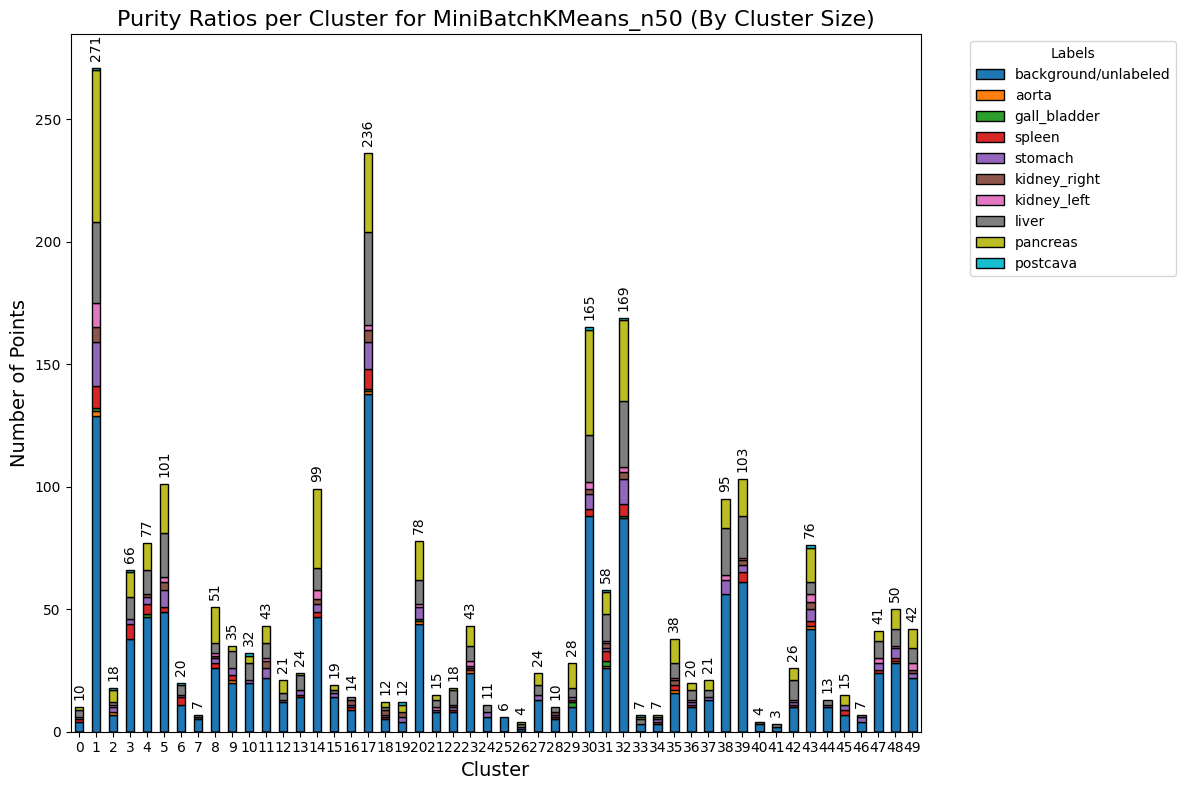

In [15]:
purity_results, algorithms = cluster_and_plot_purities(data, labels, cluster_range=[50], random_state=kmeans_random_state, normalize_bars=False)

Clustering Algorithms: 100%|██████████| 1/1 [00:00<00:00,  1.27alg/s]


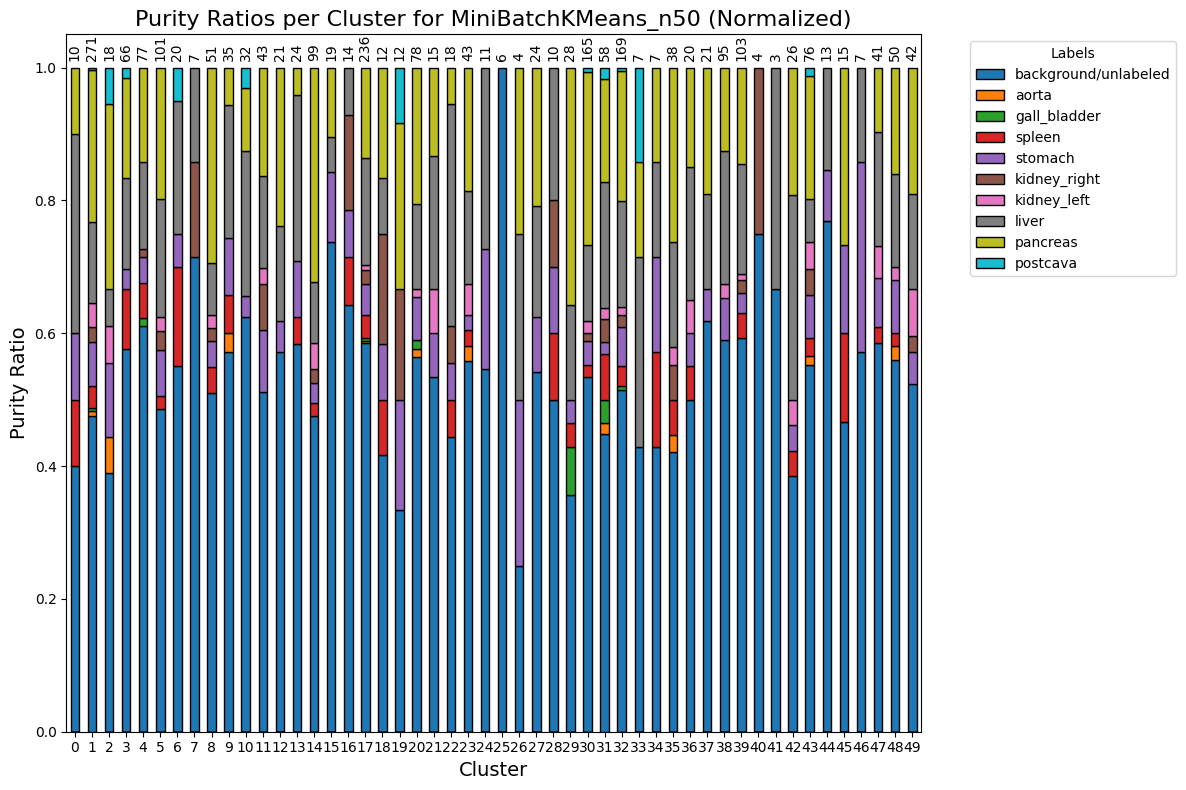

In [16]:
purity_results, algorithms = cluster_and_plot_purities(data, labels, cluster_range=[50], random_state=1)

In [ ]:
algorithms[0]

('MiniBatchKMeans_n50',
 MiniBatchKMeans(batch_size=10000, n_clusters=50, n_init='auto', random_state=1))

In [30]:
import numpy as np

def map_cluster_labels_to_sampled_points(cluster_labels: np.ndarray, all_filtered_ids: list, all_encoded_cubes: np.ndarray, sampled_points_coordinates: np.ndarray):
    """
    Maps cluster labels to sampled points and returns their coordinates and corresponding patient IDs.

    Parameters:
    cluster_labels (np.ndarray): Array of cluster labels for all points, shape [n_samples * n_points_per_sample]
    all_filtered_ids (list): List of patient IDs corresponding to each sample.
    all_encoded_cubes (np.ndarray): Array of encoded cubes, shape [n_samples, n_points_per_sample, ...]
    sampled_points_coordinates (np.ndarray): Array of coordinates, shape [n_samples, n_points_per_sample, coord_dim]

    Returns:
    all_coords (np.ndarray): Flattened array of coordinates for all points, shape [total_points, coord_dim]
    all_patient_ids (list): List of patient IDs corresponding to each coordinate.
    all_cluster_labels (np.ndarray): Flattened array of cluster labels corresponding to each coordinate.
    """
    n_samples = all_encoded_cubes.shape[0]
    n_points_per_sample = all_encoded_cubes.shape[1]

    # Reshape cluster_labels to match [n_samples, n_points_per_sample]
    reshaped_labels = cluster_labels.reshape(n_samples, n_points_per_sample)

    # Flatten the arrays
    all_coords = sampled_points_coordinates.reshape(-1, sampled_points_coordinates.shape[-1])
    all_patient_ids = np.repeat(all_filtered_ids, n_points_per_sample)
    all_cluster_labels = reshaped_labels.flatten()

    return all_coords, all_patient_ids, all_cluster_labels


from collections import defaultdict
import os
import numpy as np

def save_clusters_by_patient(all_coords, all_patient_ids, cluster_labels: list, base_path, target_clusters: list, filename_prefix='minikmeans50_random_state_1'):
    """
    Saves specified clusters as ITK-SNAP annotations for each patient.

    Parameters:
    all_coords (array): Array of coordinates representing points.
    all_patient_ids (list): List of patient IDs corresponding to the coordinates.
    cluster_labels (list): List of cluster labels corresponding to each coordinate.
    base_path (str): Base path where the annotation files will be saved.
    target_clusters (list): List of cluster labels to process.
    filename_prefix (str): Prefix for the output annotation file names.
    """
    # Filter data to include only target clusters
    cluster_mask = np.isin(cluster_labels, target_clusters)
    filtered_coords = all_coords[cluster_mask]
    filtered_patient_ids = np.array(all_patient_ids)[cluster_mask]
    filtered_cluster_labels = cluster_labels[cluster_mask]

    # Group coordinates and cluster labels by patient ID
    patient_data_map = defaultdict(lambda: {"coords": [], "labels": []})

    # Populate the map with coordinates and cluster labels for each patient ID
    for coord, patient_id, label in zip(filtered_coords, filtered_patient_ids, filtered_cluster_labels):
        patient_data_map[patient_id]["coords"].append(coord)
        patient_data_map[patient_id]["labels"].append(label)
    
    # Iterate over each patient ID and corresponding data to save annotations
    for patient_id, data in patient_data_map.items():
        pth = os.path.join(base_path, "cluster_assignments", patient_id)

        if not os.path.exists(pth):
            os.makedirs(pth)

        coords_array = np.array(data["coords"])
        labels_array = np.array(data["labels"])

        # For each unique cluster label in this patient's data, save annotations
        unique_clusters = np.unique(labels_array)
        for cluster_label in unique_clusters:
            cluster_coords = coords_array[labels_array == cluster_label]
            save_clusters_as_itk_snap_annotations(
                cluster_coords, 
                [cluster_label]*len(cluster_coords),
                base_dir=pth, 
                filename=f'{filename_prefix}_cluster_{cluster_label}.annot'
            )

In [23]:
all_coords, all_patient_ids, all_cluster_labels = map_cluster_labels_to_sampled_points(algorithms[0][1].labels_, all_filtered_ids, all_encoded_cubes, sampled_points_coordinates)
all_cluster_labels

array([30,  8, 12, ..., 39, 17, 30], dtype=int32)

In [36]:
save_clusters_by_patient(all_coords.numpy(), all_patient_ids, all_cluster_labels, base_path, target_clusters=[40,41,42], filename_prefix='minikmeans50_random_state_1')

Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00000002/minikmeans50_random_state_1_cluster_40.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00000110/minikmeans50_random_state_1_cluster_42.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00000351/minikmeans50_random_state_1_cluster_42.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00000878/minikmeans50_random_state_1_cluster_42.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00000928/minikmeans50_random_state_1_cluster_42.annot'.
Successfully saved 189 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00001

In [ ]:
# TODO this only works when a cluster has points only from a single CT
c40_coords, c40_patient_ids = map_cluster_labels_to_sampled_points(algorithms[0][1].labels_, all_filtered_ids, cluster=40)
c40_labels = [[40]] * len(c40_coords)
c41_coords, c41_patient_ids = map_cluster_labels_to_sampled_points(algorithms[0][1].labels_, all_filtered_ids, cluster=41)
c41_labels = [[41]] * len(c41_coords)
c42_coords, c42_patient_ids = map_cluster_labels_to_sampled_points(algorithms[0][1].labels_, all_filtered_ids, cluster=42)
c42_labels = [[42]] * len(c42_coords)
c42_coords, c42_patient_ids

In [60]:
from collections import defaultdict
import os
import numpy as np

def save_clusters_by_patient(all_coords, all_patient_ids, cluster_labels: int, base_path, filename_prefix='minikmeans50_random_state_1'):
    """
    Saves clusters as ITK-SNAP annotations for each patient.
    
    Parameters:
    all_coords (array): Array of coordinates representing points.
    all_patient_ids (list): List of patient IDs corresponding to the coordinates.
    cluster_labels (int): TODO make this a List of cluster labels corresponding to each coordinate.
    base_path (str): Base path where the annotation files will be saved.
    filename_prefix (str): Prefix for the output annotation file names.
    """
    # Group coordinates and cluster labels by patient ID
    patient_data_map = defaultdict(lambda: {"coords": [], "labels": []})
    
    # Populate the map with coordinates and cluster labels for each patient ID
    for coord, patient_id in zip(all_coords, all_patient_ids):
        patient_data_map[patient_id]["coords"].append(coord)
        patient_data_map[patient_id]["labels"].append(cluster_labels)
    
    # Iterate over each patient ID and corresponding data to save annotations
    for patient_id, data in patient_data_map.items():
        pth = os.path.join(base_path, "cluster_assignments", patient_id)
        
        if not os.path.exists(pth):
            os.makedirs(pth)
        
        # Convert lists to numpy arrays before passing them to the function
        coords_array = np.array(data["coords"])
        labels_array = np.array(data["labels"])
        
        # Call the function to save clusters as annotations
        save_clusters_as_itk_snap_annotations(
            coords_array, 
            labels_array,
            base_dir=pth, 
            filename=f'{filename_prefix}_cluster_{cluster_labels}.annot'
        )

# Example usage:
# save_clusters_by_patient(c40_coords, c40_patient_ids, cluster_labels, base_path)

In [36]:
c40_coords.shape

(4, 3)

In [40]:
np.array(c40_labels).shape

(4, 1)

In [61]:
save_clusters_by_patient(c40_coords, c40_patient_ids, 40, base_path)

Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00000002/minikmeans50_random_state_1_cluster_40.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00001662/minikmeans50_random_state_1_cluster_40.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00001942/minikmeans50_random_state_1_cluster_40.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00004098/minikmeans50_random_state_1_cluster_40.annot'.


In [62]:
save_clusters_by_patient(c41_coords, c41_patient_ids, 41, base_path)

Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00002650/minikmeans50_random_state_1_cluster_41.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00003644/minikmeans50_random_state_1_cluster_41.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00003876/minikmeans50_random_state_1_cluster_41.annot'.


In [63]:
save_clusters_by_patient(c42_coords, c42_patient_ids, 42, base_path)

Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00000110/minikmeans50_random_state_1_cluster_42.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00000351/minikmeans50_random_state_1_cluster_42.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00000878/minikmeans50_random_state_1_cluster_42.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00000928/minikmeans50_random_state_1_cluster_42.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_00001348/minikmeans50_random_state_1_cluster_42.annot'.
Successfully saved 63 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/BDMAP_000016

In [66]:
len(c42_coords)

26

In [64]:
pd.DataFrame(c42_patient_ids).value_counts()

BDMAP_00000110    1
BDMAP_00002753    1
BDMAP_00004231    1
BDMAP_00004098    1
BDMAP_00003577    1
BDMAP_00003265    1
BDMAP_00003154    1
BDMAP_00003013    1
BDMAP_00002650    1
BDMAP_00000351    1
BDMAP_00002569    1
BDMAP_00002212    1
BDMAP_00001662    1
BDMAP_00001348    1
BDMAP_00000928    1
BDMAP_00000878    1
BDMAP_00004360    1
dtype: int64

In [58]:
pth = os.path.join(base_path, "cluster_assignments")

if not os.path.exists(pth):
    os.makedirs(pth)

save_clusters_as_itk_snap_annotations(c40_coords, c40_labels, base_dir=pth,  filename='minikmeans50_random_state_1.annot')

Successfully saved 693 LandmarkAnnotations to 'data/generated-data/cube_samples/random_seed_2/cluster_assignments/minikmeans50_random_state_1.annot'.


In [60]:
len(all_filtered_ids)

43

In [ ]:
# As a test, save true labels
# save_clusters_as_itk_snap_annotations(sampled_points_coordinates[0].numpy(), labels[:55], filename='true_labels.annot')

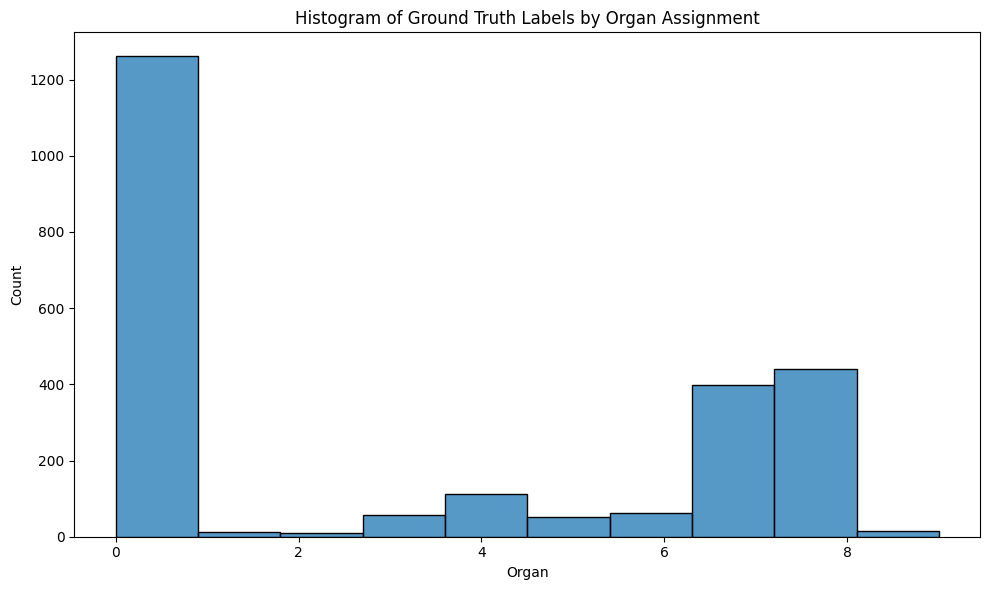

Clustering Algorithms:   0%|          | 0/1 [00:00<?, ?alg/s]


TypeError: cannot unpack non-iterable MiniBatchKMeans object

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Plot histogram of ground truth labels by organ assignment
plt.figure(figsize=(10, 6))
sns.histplot(labels, bins=len(reverse_organs_dict), kde=False)
plt.title("Histogram of Ground Truth Labels by Organ Assignment")
plt.xlabel("Organ")
plt.ylabel("Count")
# plt.xticks(ticks=list(reverse_organs_dict.values()), labels=list(reverse_organs_dict.keys()), rotation=45)
plt.tight_layout()
plt.show()


purity_results = calculate_purities(
    data=data,
    labels=labels,
    algorithms=[minibatchkmeans_38],
    plot=True  # Set to False if you don't want plots
)

# Plot histogram of points assigned in each cluster
cluster_assignments = purity_results['Cluster']

plt.figure(figsize=(10, 6))
sns.histplot(cluster_assignments, bins=len(cluster_assignments.unique()), kde=False)
plt.title("Histogram of Points Assigned in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Pancreas vs. Background Labels Purity

In [ ]:
pancreas_vs_background_labels = middle_binary_labels

## Running on All Flattened Data

### KMeans for range(2, 100, 2) Clusters

In [ ]:
import warnings

# Suppress only the specific FutureWarning about 'observed'
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="The default of observed=False is deprecated and will be changed to True in a future version of pandas."
)


from sklearn.cluster import MiniBatchKMeans#, Birch - too slow
import hdbscan  # Optional, if you decide to use HDBSCAN

# Initialize an empty list to hold all algorithm configurations
algorithms = []

cluster_range = range(2, 102, 2)

# Loop through the cluster range to create MiniBatchKMeans and Birch instances
for n_clusters in cluster_range:
    # MiniBatchKMeans
    mbk_name = f'MiniBatchKMeans_n{n_clusters}'
    mbk = MiniBatchKMeans(
        n_clusters=n_clusters,
        random_state=42,
        batch_size=10000,
        init='k-means++',  # You can adjust initialization if needed
        n_init=10  # Number of initializations to perform
    )
    algorithms.append((mbk_name, mbk))


# Calculate purities
purity_results = calculate_purities(
    data=full_pca_data,
    labels=pancreas_vs_background_labels,
    algorithms=algorithms,
    plot=True  # Set to False if you don't want plots
)

# Display the results
purity_results

In [ ]:
count_zeros = (pancreas_vs_background_labels == 0).sum().item()
count_ones = (pancreas_vs_background_labels == 1).sum().item()

print(count_zeros, count_ones)

print(count_zeros / len(pancreas_vs_background_labels), count_ones / len(pancreas_vs_background_labels))

### OPTICS

In [ ]:
import warnings

# Suppress only the specific FutureWarning about 'observed'
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="The default of observed=False is deprecated and will be changed to True in a future version of pandas."
)


from sklearn.cluster import OPTICS

# Initialize an empty list to hold all algorithm configurations
algorithms = []

cluster_range = range(0,1)

# Loop through the cluster range to create MiniBatchKMeans and Birch instances
for n_clusters in cluster_range:
    mbk_name = f'OPTICS_{n_clusters}'
    mbk = OPTICS(
    )
    algorithms.append((mbk_name, mbk))


# Calculate purities
purity_results = calculate_purities(
    data=middle_vectors_full_pca,
    labels=cluster_labels_mini10,
    algorithms=algorithms,
    plot=True  # Set to False if you don't want plots
)

# Display the results
purity_results

### HDBSCAN

In [ ]:
import warnings

# Suppress only the specific FutureWarning about 'observed'
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="The default of observed=False is deprecated and will be changed to True in a future version of pandas."
)


from hdbscan import HDBSCAN

# Initialize an empty list to hold all algorithm configurations
algorithms = []

cluster_range = range(0,1)

# Loop through the cluster range to create MiniBatchKMeans and Birch instances
for n_clusters in cluster_range:
    mbk_name = f'hdbscan_{n_clusters}'
    mbk = HDBSCAN(
    )
    algorithms.append((mbk_name, mbk))


# Calculate purities
purity_results = calculate_purities(
    data=middle_vectors_full_pca,
    labels=cluster_labels_mini10,
    algorithms=algorithms,
    plot=True  # Set to False if you don't want plots
)

# Display the results
purity_results

## Pairwise Similarities

### Between Middle Vectors

In [72]:
import numpy as np


def compute_cosine_similarity(matrix):
    """
    Compute the pairwise cosine similarity matrix for a 2D NumPy array.

    Parameters:
    - matrix (np.ndarray): A 2D NumPy array of shape (n_samples, n_features).

    Returns:
    - cosine_sim_matrix (np.ndarray): A 2D NumPy array of shape (n_samples, n_samples) containing cosine similarities.
    """
    # Step 1: Normalize the matrix
    # Add a small epsilon to avoid division by zero
    norm = np.linalg.norm(matrix, axis=1, keepdims=True) + 1e-10
    normalized_matrix = matrix / norm

    # Step 2: Compute cosine similarity as dot product of normalized vectors
    cosine_sim_matrix = np.dot(normalized_matrix, normalized_matrix.T)

    return cosine_sim_matrix

In [73]:
middle_vector_dot_products = torch.mm(middle_vectors_full_pca, middle_vectors_full_pca.T)

In [76]:
middle_vector_cosines = compute_cosine_similarity(middle_vectors_full_pca.numpy())

In [ ]:
middle_vector_dot_products

In [ ]:
pd.DataFrame(middle_vector_dot_products.numpy()).describe()

In [ ]:
pd.DataFrame(middle_vector_cosines).describe()

In [ ]:
plt.imshow(middle_vector_cosines, cmap='hot')#, interpolation='nearest')

### Between Vectors within same CT

In [ ]:
flat_enc_cts = all_encoded_cubes[0]

flat_enc_cts.shape

In [ ]:
first_ct_flattened = flatten_features(flat_enc_cts.unsqueeze(0))

first_ct_flattened.shape

## Check for Repeat/High Similarity Vectors

Do this for within a CT scan

- [] TODO

In [38]:
import numpy as np

res, counts = np.unique(full_pca_data, axis=0, return_counts=True)

In [ ]:
counts

In [ ]:
pd.DataFrame(counts).value_counts()

In [ ]:
full_data_df.value_counts()

# Saving Clusters as ITK-SNAP Annotations Code

In [35]:
import xml.etree.ElementTree as ET
import os

def save_clusters_as_itk_snap_annotations(points, clusters, base_dir="results/itk-snap-annotations", filename='annotations.annot', slice_range=10, image_size=512):
    """
    Saves 3D points as annotations on multiple slices in an .annot file for ITK-SNAP.

    Parameters:
    - points (np.ndarray): Array of shape (n_points, 3) containing x, y, z coordinates.
    - clusters (np.ndarray): Array of shape (n_points,) containing cluster labels (integers).
    - filename (str): Output filename for the .annot file.
    - slice_range (int): Number of slices above and below the point to create annotations.
    - image_size (int or tuple): Size of the image (assumed cubic if int, or specify (x_size, y_size, z_size)).
    """
    clusters = np.array(clusters)
    points = np.array(points)

    if points.shape[0] != clusters.shape[0]:
        raise ValueError("Number of points and clusters must be the same.")

    n_points = points.shape[0]

    # Define fixed red color for all annotations
    color = "1 0 0"  # Fully red

    # Initialize XML structure
    registry = ET.Element('registry')

    # Add header entries
    ET.SubElement(registry, 'entry', key="Format", value="ITK-SNAP Annotation File")
    ET.SubElement(registry, 'entry', key="FormatDate", value="20241014")  # FormatDate as YYYYMMDD

    # Annotations folder
    annotations_folder = ET.SubElement(registry, 'folder', key="Annotations")
    element_counter = 0  # To keep track of Element[n] keys

    # Determine image dimensions
    if isinstance(image_size, int):
        x_max = y_max = z_max = image_size
    elif isinstance(image_size, tuple) and len(image_size) == 3:
        x_max, y_max, z_max = image_size
    else:
        raise ValueError("image_size must be an int or a tuple of three ints.")

    for i in range(n_points):
        x, y, z = points[i]
        cluster = clusters[i]

        # For each plane
        for plane in range(3):
            if plane == 0:  # Sagittal plane (X axis)
                coord = int(round(x))
                coord_min = max(0, coord - slice_range)
                coord_max = min(x_max - 1, coord + slice_range)
            elif plane == 1:  # Coronal plane (Y axis)
                coord = int(round(y))
                coord_min = max(0, coord - slice_range)
                coord_max = min(y_max - 1, coord + slice_range)
            elif plane == 2:  # Axial plane (Z axis)
                coord = int(round(z))
                coord_min = max(0, coord - slice_range)
                coord_max = min(z_max - 1, coord + slice_range)

            # Loop over the coordinate range
            for c in range(coord_min, coord_max + 1):
                element_key = f"Element[{element_counter}]"
                element_folder = ET.SubElement(annotations_folder, 'folder', key=element_key)

                # Position adjusted for the current slice
                if plane == 0:
                    pos = f"{float(c)} {float(y)} {float(z)}"
                elif plane == 1:
                    pos = f"{float(x)} {float(c)} {float(z)}"
                elif plane == 2:
                    pos = f"{float(x)} {float(y)} {float(c)}"

                # Define entries for LandmarkAnnotation
                ET.SubElement(element_folder, 'entry', key="Color", value=color)
                ET.SubElement(element_folder, 'entry', key="Offset", value="0 0")  # No offset
                ET.SubElement(element_folder, 'entry', key="Plane", value=str(plane))
                ET.SubElement(element_folder, 'entry', key="Pos", value=pos)
                ET.SubElement(element_folder, 'entry', key="Selected", value="0")
                ET.SubElement(element_folder, 'entry', key="Tags", value="")
                ET.SubElement(element_folder, 'entry', key="Text", value=str(cluster))  # Removed "Cluster"
                ET.SubElement(element_folder, 'entry', key="Type", value="LandmarkAnnotation")
                ET.SubElement(element_folder, 'entry', key="VisibleInAllPlanes", value="1")  # Visible in all planes
                ET.SubElement(element_folder, 'entry', key="VisibleInAllSlices", value="0")  # Visible only on this slice

                element_counter += 1

    # Update ArraySize to reflect the actual number of elements
    ET.SubElement(annotations_folder, 'entry', key="ArraySize", value=str(element_counter))

    # Create the DOCTYPE declaration
    doctype = '''<!DOCTYPE registry [
<!ELEMENT registry (entry*,folder*)>
<!ELEMENT folder (entry*,folder*)>
<!ELEMENT entry EMPTY>
<!ATTLIST folder key CDATA #REQUIRED>
<!ATTLIST entry key CDATA #REQUIRED>
<!ATTLIST entry value CDATA #REQUIRED>
]>'''

    # Generate the XML tree
    tree = ET.ElementTree(registry)

    # Write to file with XML declaration and DOCTYPE
    with open(os.path.join(base_dir, filename), 'w') as f:
        f.write('<?xml version="1.0" encoding="UTF-8" ?>\n')
        f.write(doctype + '\n')
        tree.write(f, encoding='unicode')

    total_annotations = element_counter
    print(f"Successfully saved {total_annotations} LandmarkAnnotations to '{os.path.join(base_dir, filename)}'.")

# Plotting 🗾

### Function Definitions (Long) 📚

Functions for:

- Plotting 2D, with labels and cluster centroids
- Plotting 3D, with labels and cluster centroids
- 3D Interactive plot of the same
- Saving to ITK-SNAP landmarks

In [193]:
!pip install plotly

     |████████████████████████████████| 19.1 MB 13.1 MB/s eta 0:00:01
You should consider upgrading via the '/scratch4/randalburns/DiffTumor/venv-py38/bin/python -m pip install --upgrade pip' command.


In [194]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import colormaps  # Import the correct module for colormaps

organs_dict = {
    'unlabeled/background': 0,
    'aorta': 1,
    'gall_bladder': 2,
    'spleen': 3,
    'stomach': 4,
    'kidney_right': 5,
    'kidney_left': 6,
    'liver': 7,
    'pancreas': 8,
    'postcava': 9
}

reverse_organs_dict = {v: k for k, v in organs_dict.items()}

# Function to plot 2D scatter plot with annotations and cluster centroids with variance ellipses
def plot_2d(features_high_dim, labels, patient_ids, clusters, title):
    """
    Plots a 2D PCA scatter plot with data points colored by ground truth labels and cluster centroids.

    Parameters:
    - features_high_dim: NumPy array of shape (n_samples, n_features), original high-dimensional data.
    - labels: List or array of ground truth label numbers.
    - patient_ids: List of patient ID strings.
    - clusters: NumPy array of cluster assignments.
    - title: Title of the plot.
    """
    
    # Perform PCA to reduce to 2D
    features_2d = features_high_dim
    if features_high_dim.shape[1] > 2:
        pca_2d = PCA(n_components=2)
        features_2d = pca_2d.fit_transform(features_high_dim)
    
    plt.figure(figsize=(12, 8))
    
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Using 'tab10' colormap for up to 10 colors

    # Create a color for each label
    label_colors = {label: colors(i) for i, label in enumerate(unique_labels)}
    point_colors = [label_colors[label] for label in labels]
    
    # Create a reverse mapping for hover information
    label_names = [reverse_organs_dict.get(label, f'Label {label}') for label in labels]
    
    # Plot data points
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=point_colors, s=50, alpha=0.7)

    # Add hover information (using mplcursors for interactivity)
    try:
        import mplcursors
        cursor = mplcursors.cursor(scatter, hover=True)
        cursor.connect("add", lambda sel: sel.annotation.set_text(label_names[sel.index]))
    except ImportError:
        print("mplcursors is not installed. Hover functionality is disabled.")

    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    # Compute and plot centroids and variance ellipses
    unique_clusters = np.unique(clusters)
    cmap = colormaps.get_cmap('tab10')

    used_colors = {}
    centroid_labels = []

    for i, cluster in enumerate(unique_clusters):
        cluster_points = features_2d[clusters == cluster]
        if cluster_points.shape[0] == 0:
            continue  # Skip empty clusters
        centroid = cluster_points.mean(axis=0)
        covariance = np.cov(cluster_points, rowvar=False)
        
        if covariance.shape == (2, 2):
            eigenvalues, eigenvectors = np.linalg.eigh(covariance)
            
            # Sort eigenvalues and eigenvectors
            order = eigenvalues.argsort()[::-1]
            eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
            
            # Compute angle for the ellipse
            angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
            
            # Width and height are "full" widths, so multiply by 2
            width, height = 2 * np.sqrt(eigenvalues)
            
            # Create and add the ellipse patch
            ellipse = Ellipse(xy=centroid, width=width, height=height, angle=angle,
                              edgecolor=cmap(i), facecolor='none', linewidth=2)
            plt.gca().add_patch(ellipse)
        
        # Plot centroid as 'X'
        plt.scatter(centroid[0], centroid[1], marker='X', s=200, c=[cmap(i)], label='Centroid')
        used_colors['Centroid'] = cmap(i)
        centroid_labels.append('Centroid')

    # Create legend for ground truth labels
    label_handles = [
        plt.Line2D([0], [0], marker='o', color='w', label=reverse_organs_dict.get(label, f'Label {label}'),
                   markerfacecolor=color, markersize=10) 
        for label, color in label_colors.items()
    ]

    # Create legend for centroids
    centroid_handles = [
        plt.Line2D([0], [0], marker='X', color='w', label='Centroid',
                   markerfacecolor=used_colors['Centroid'], markersize=10)
    ]

    # Combine both legends
    plt.legend(handles=label_handles + centroid_handles, loc='lower left')
    plt.grid(True)
    plt.show()        
# Function to plot 3D scatter plot with annotations and cluster centroids
def plot_3d(features_high_dim, labels, patient_ids, clusters, title):
    """
    Plots a 3D PCA scatter plot with data points colored by ground truth labels and cluster centroids.

    Parameters:
    - features_high_dim: NumPy array of shape (n_samples, n_features), original high-dimensional data.
    - labels: List or array of ground truth label numbers.
    - patient_ids: List of patient ID strings.
    - clusters: NumPy array of cluster assignments.
    - title: Title of the plot.
    """
    # Perform PCA to reduce to 3D
    features_3d = features_high_dim
    if features_high_dim.shape[1] > 3:
        pca_3d = PCA(n_components=3)
        features_3d = pca_3d.fit_transform(features_high_dim)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Define colors for ground truth labels using organs_dict
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Using 'tab10' colormap
    
    # Create a color for each label
    label_colors = {label: colors(i) for i, label in enumerate(unique_labels)}
    point_colors = [label_colors[label] for label in labels]
    
    # Create label names for hover and legend
    label_names = [reverse_organs_dict.get(label, f'Label {label}') for label in labels]
    
    # Plot data points
    scatter = ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2],
                         c=point_colors, s=50, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')

    # Compute and plot centroids
    unique_clusters = np.unique(clusters)
    cmap = colormaps.get_cmap('tab10')
    
    centroids = []
    for i, cluster in enumerate(unique_clusters):
        cluster_points = features_3d[clusters == cluster]
        if cluster_points.shape[0] == 0:
            continue
        centroid = cluster_points.mean(axis=0)
        centroids.append(centroid)
        ax.scatter(centroid[0], centroid[1], centroid[2], marker='X', s=200, c=[cmap(i)], label='Centroid')

    # Create legend for ground truth labels
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=reverse_organs_dict.get(label, f'Label {label}'),
                          markerfacecolor=color, markersize=10) for label, color in label_colors.items()]
    
    # Create legend for centroids (single entry)
    centroid_handle = plt.Line2D([0], [0], marker='X', color='w', label='Centroid',
                                 markerfacecolor='black', markersize=10)
    
    # Combine legends
    ax.legend(handles=handles + [centroid_handle], loc='best')
    plt.show()

import plotly.graph_objs as go
import plotly.express as px
import numpy as np
from typing import Optional, Tuple

def plot_interactive_3d_scatter(
    coordinates: np.ndarray,
    cluster_labels: np.ndarray,
    ground_truth_labels: Optional[np.ndarray] = None,
    axis_min: Optional[Tuple[int, int, int]] = (-25, -25, -25),
    axis_max: Optional[Tuple[int, int, int]] = (50, 50, 50),
    title: str = "Interactive 3D Scatter Plot",
    show_legend: bool = True
):
    """
    Plots an interactive 3D scatter plot with detailed legends for each ground truth organ and cluster centroids.

    Parameters:
    - coordinates (np.ndarray): Array of shape (n, 3) representing 3D coordinates.
    - cluster_labels (np.ndarray): Array of shape (n,) containing cluster assignments for each point.
    - ground_truth_labels (Optional[np.ndarray]): Array of shape (n,) containing ground truth labels for each point.
    - axis_range (Optional[Tuple[int, int, int]]): Tuple specifying the max range for x, y, z axes. Defaults to (512, 512, 512).
    - title (str): Title of the plot.
    - show_legend (bool): Whether to display the legend.

    Returns:
    - A Plotly Figure object displaying the interactive 3D scatter plot.
    """

    # Validate input dimensions
    if coordinates.ndim != 2 or coordinates.shape[1] != 3:
        raise ValueError("Coordinates array must be of shape (n, 3).")

    n_points = coordinates.shape[0]

    if cluster_labels.ndim != 1 or cluster_labels.shape[0] != n_points:
        raise ValueError("cluster_labels must be a 1D array with the same length as coordinates.")

    if ground_truth_labels is not None:
        if ground_truth_labels.ndim != 1 or ground_truth_labels.shape[0] != n_points:
            raise ValueError("ground_truth_labels must be a 1D array with the same length as coordinates.")

    # Extract X, Y, Z coordinates
    x = coordinates[:, 0]
    y = coordinates[:, 1]
    z = coordinates[:, 2]

    # Handle ground truth labels
    if ground_truth_labels is not None:
        unique_gt = np.unique(ground_truth_labels)
        num_gt = len(unique_gt)
        gt_color_palette = px.colors.qualitative.Light24
        if num_gt > len(gt_color_palette):
            extended_gt_palette = gt_color_palette * (num_gt // len(gt_color_palette) + 1)
        else:
            extended_gt_palette = gt_color_palette
        gt_colors = {gt: extended_gt_palette[i] for i, gt in enumerate(unique_gt)}
    else:
        gt_colors = {}

    # Create ground truth traces
    data = []
    if ground_truth_labels is not None:
        for gt in unique_gt:
            organ_name = reverse_organs_dict.get(int(gt), f'Label {gt}')
            indices = np.where(ground_truth_labels == gt)[0]
            trace = go.Scatter3d(
                x=x[indices],
                y=y[indices],
                z=z[indices],
                mode='markers',
                marker=dict(
                    size=5,
                    color=gt_colors[gt],
                    opacity=0.8
                ),
                name=organ_name,
                hovertemplate=
                    "<b>Organ:</b> %{text}<br>" +
                    "<b>X:</b> %{x:.2f}<br>" +
                    "<b>Y:</b> %{y:.2f}<br>" +
                    "<b>Z:</b> %{z:.2f}<br>" +
                    "<extra></extra>",
                text=[organ_name] * len(indices)
            )
            data.append(trace)
    else:
        # If no ground truth labels, plot all points with a single color
        trace = go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='markers',
            marker=dict(
                size=5,
                color='blue',
                opacity=0.8
            ),
            name='Data Points',
            hovertemplate=
                "<b>X:</b> %{x:.2f}<br>" +
                "<b>Y:</b> %{y:.2f}<br>" +
                "<b>Z:</b> %{z:.2f}<br>" +
                "<extra></extra>",
        )
        data.append(trace)

    # Calculate and plot centroids as 'X'
    unique_clusters = np.unique(cluster_labels)
    num_clusters = len(unique_clusters)
    color_palette = px.colors.qualitative.Plotly
    if num_clusters > len(color_palette):
        extended_palette = color_palette * (num_clusters // len(color_palette) + 1)
    else:
        extended_palette = color_palette
    cluster_colors = {cluster: extended_palette[i] for i, cluster in enumerate(unique_clusters)}

    centroids = []
    for cluster in unique_clusters:
        indices = np.where(cluster_labels == cluster)[0]
        if len(indices) == 0:
            continue
        centroid = coordinates[indices].mean(axis=0)
        centroids.append({
            'cluster': cluster,
            'x': centroid[0],
            'y': centroid[1],
            'z': centroid[2],
            'color': cluster_colors[cluster]
        })

    if centroids:
        centroid_trace = go.Scatter3d(
            x=[c['x'] for c in centroids],
            y=[c['y'] for c in centroids],
            z=[c['z'] for c in centroids],
            mode='markers',
            marker=dict(
                size=8,
                color=[c['color'] for c in centroids],
                symbol='x',
                line=dict(width=2),
                opacity=1.0
            ),
            name='Centroids',
            hovertemplate=
                "<b>Centroid of Cluster:</b> %{text}<br>" +
                "<b>X:</b> %{x:.2f}<br>" +
                "<b>Y:</b> %{y:.2f}<br>" +
                "<b>Z:</b> %{z:.2f}<br>" +
                "<extra></extra>",
            text=[f'Cluster {c["cluster"]}' for c in centroids]
        )
        data.append(centroid_trace)

    layout = go.Layout(
        title=title,
        scene=dict(
            xaxis=dict(title='X'),#, range=[axis_min[0], axis_max[0]]),
            yaxis=dict(title='Y'),#, range=[axis_min[1], axis_max[1]]),
            zaxis=dict(title='Z')#, range=[axis_min[2], axis_max[2]]),
        ),
        legend=dict(
            itemsizing='constant',
            title="Organ Labels",
        ),
        margin=dict(l=0, r=0, b=0, t=50),
        showlegend=show_legend
    )

    # # Define layout with customizable axis ranges
    # layout = go.Layout(
    #     title=title,
    #     scene=dict(
    #         xaxis=dict(title='X', range=[axis_min[0], axis_max[0]]),
    #         yaxis=dict(title='Y', range=[axis_min[1], axis_max[1]]),
    #         zaxis=dict(title='Z', range=[axis_min[2], axis_max[2]]),
    #     ),
    #     legend=dict(
    #         itemsizing='constant',
    #         title="Organ Labels",
    #     ),
    #     margin=dict(l=0, r=0, b=0, t=50),
    #     showlegend=show_legend
    # )

    fig = go.Figure(data=data, layout=layout)
    fig.show()

In [32]:
base_cluster_results_dir = "data/generated-data/clustering-results"

## Unlabeled

A.k.a. the plotting function that performs best on Unlabeled metrics: Davies Bouldin Score, Calinski Harabasz Score

That is MiniBatchKmeans for DB and CH scores, but OPTICS for Silhouette Score. OPTICS can only be run on small datasets

<font color='red'>Truth is, from the hyperparameter_search.ipynb, there is no clear winner. All models perform terrible on the metrics. So use MiniBatchKMeans</font>

In [34]:
# Put your best clustering algorithm here

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import OPTICS, DBSCAN


minibatchkmeans_10 = MiniBatchKMeans(n_clusters=10, random_state=42)
minibatchkmeans_6 = MiniBatchKMeans(n_clusters=6, random_state=42)
minibatchkmeans_2 = MiniBatchKMeans(n_clusters=2, random_state=42)
minibatchkmeans_4 = MiniBatchKMeans(n_clusters=4, random_state=42)
minibatchkmeans_8 = MiniBatchKMeans(n_clusters=8, random_state=42)
minibatchkmeans_12 = MiniBatchKMeans(n_clusters=12, random_state=42)
minibatchkmeans_14 = MiniBatchKMeans(n_clusters=14, random_state=42)

optics = OPTICS()
dbscan = DBSCAN()

In [35]:
flattened_encoded_cts = flatten_features(all_encoded_cubes)

flattened_encoded_cts_scaled = StandardScaler().fit_transform(flattened_encoded_cts)

In [36]:
middle_unscaled, _ = extract_middle_vectors(flattened_encoded_cts)

## On Raw, Unscaled Data

In [37]:
from sklearn.manifold import TSNE

tsne_2d = TSNE(n_components=2, random_state=42).fit_transform(middle_unscaled)

In [38]:
tsne_3d = TSNE(n_components=3, random_state=42).fit_transform(middle_unscaled)

In [41]:
minibatchkmeans_10.fit(middle_unscaled)

MiniBatchKMeans(n_clusters=10, random_state=42)

In [42]:
minibatchkmeans_10.labels_

array([7, 8, 3, ..., 7, 7, 3], dtype=int32)

### On a Single CT (Cleaner)

mplcursors is not installed. Hover functionality is disabled.


/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_30402/1200743870.py:43: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



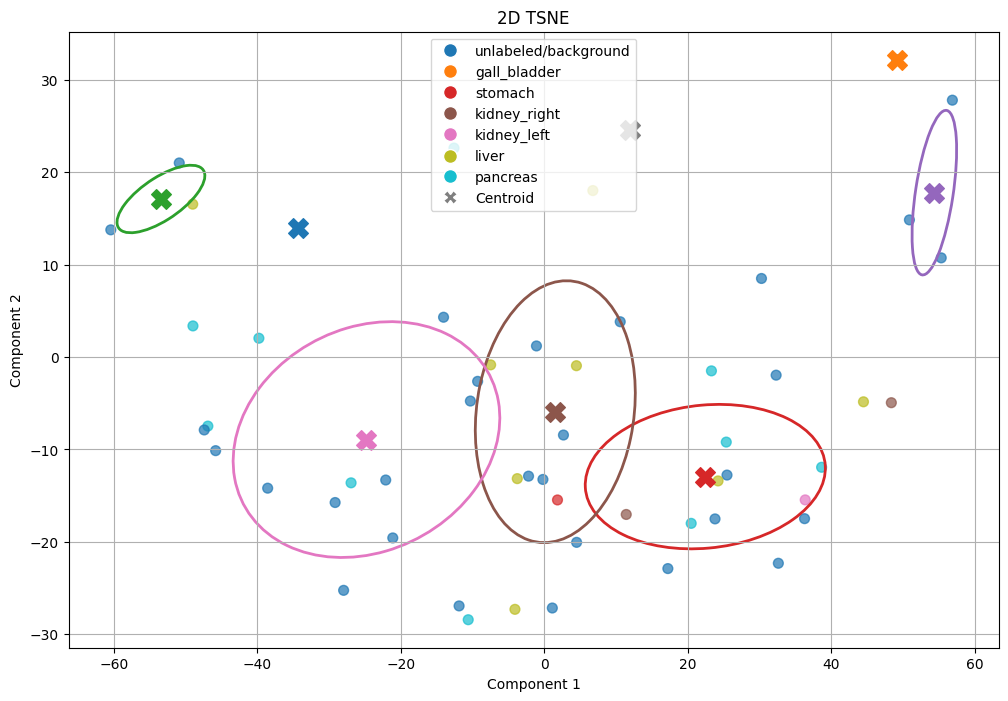

In [87]:
plot_2d(tsne_2d[:55], sampled_points_multi_organ_labels.numpy().flatten()[:55], all_filtered_ids[:55], minibatchkmeans_10.labels_[:55], "2D TSNE")

### On all 45 CTs

/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_30402/899656148.py:43: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



mplcursors is not installed. Hover functionality is disabled.


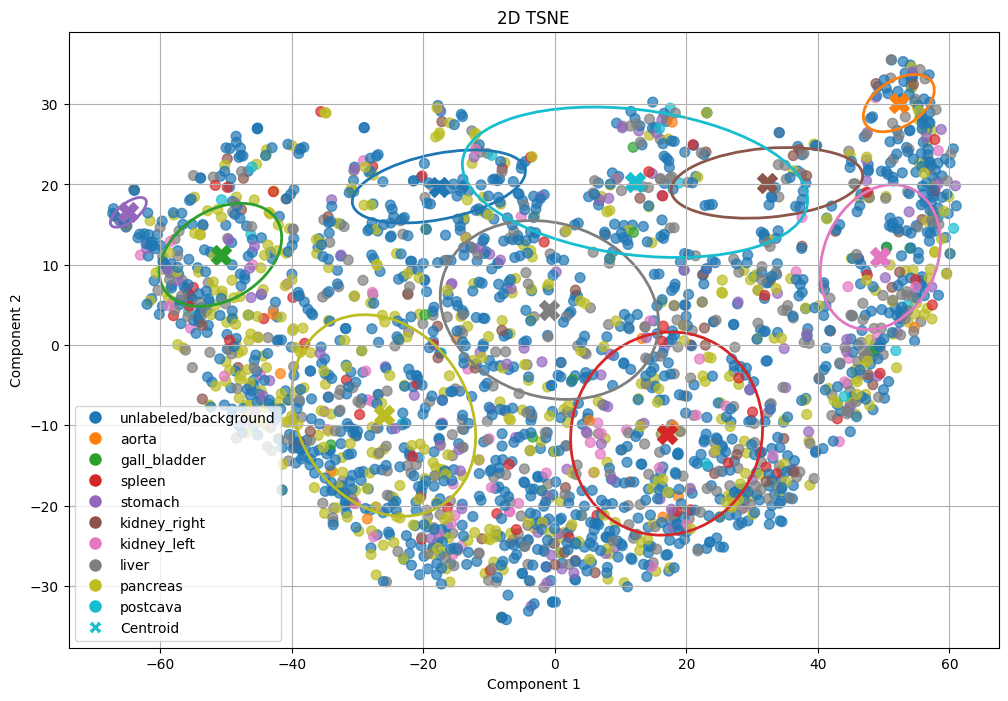

In [76]:
plot_2d(tsne_2d, sampled_points_multi_organ_labels.numpy().flatten(), all_filtered_ids, minibatchkmeans_10.labels_, "2D TSNE")

/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_5259/1200743870.py:144: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Using 'tab10' colormap


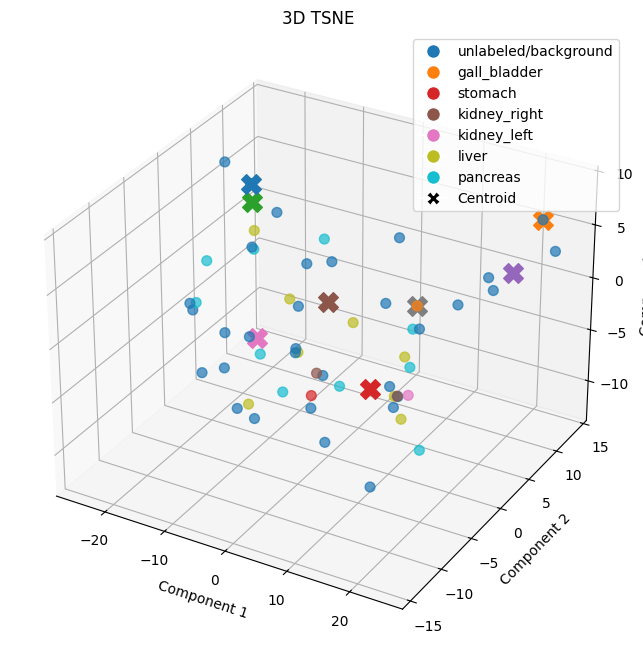

In [43]:
plot_3d(tsne_3d[:55], sampled_points_multi_organ_labels.numpy().flatten()[:55], all_filtered_ids[:55], minibatchkmeans_10.labels_[:55], "3D TSNE")

/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_30402/1200743870.py:144: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



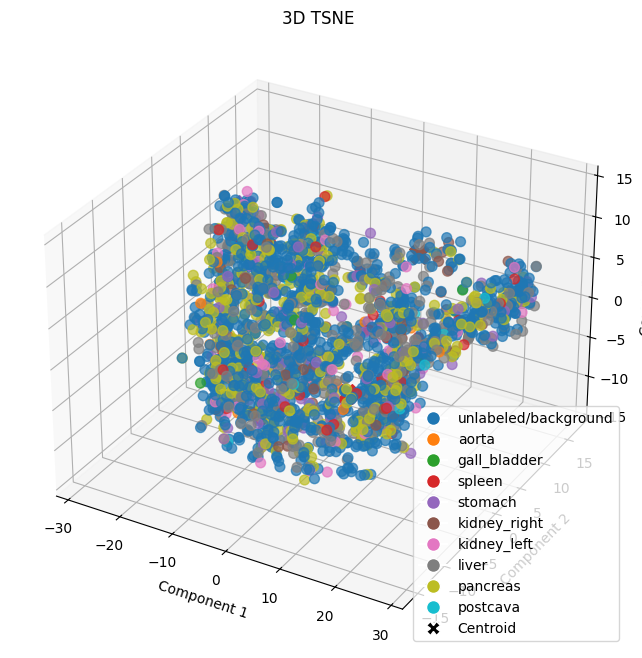

In [85]:
plot_3d(tsne_3d, sampled_points_multi_organ_labels.numpy().flatten(), all_filtered_ids, minibatchkmeans_10.labels_, "3D TSNE")

In [46]:
pd.DataFrame(tsne_3d[:55]).describe()

,0,1,2
count,55.000000,55.000000,55.000000
mean,0.982329,-0.719148,-1.420108
std,12.985308,6.147784,5.081944
min,-24.688032,-14.226270,-12.386585
25%,-7.553623,-4.977463,-5.208958
50%,1.964806,-0.256702,-1.317239
75%,11.248823,2.363584,1.889115
max,24.667101,13.544825,8.897179


In [54]:
plot_interactive_3d_scatter(tsne_3d[:55], minibatchkmeans_10.labels_[:55], sampled_points_multi_organ_labels.numpy().flatten()[:55])#, axis_range=(np.max(tsne_3d),np.max(tsne_3d),np.max(tsne_3d)))

In [55]:
plot_interactive_3d_scatter(tsne_3d, minibatchkmeans_10.labels_, sampled_points_multi_organ_labels.numpy().flatten(), axis_max=(np.max(tsne_3d),np.max(tsne_3d),np.max(tsne_3d)))

## On PCA, keeping all 8 components

In [63]:
from sklearn.decomposition import PCA

pca_8_features = PCA().fit_transform(flattened_encoded_cts_scaled)

### Only Using middle vectors

I.e. vectors with coordinates $(12,12,12)$ within the encoded $24^3$

In [64]:
middle_vecs, indices = extract_middle_vectors(pca_8_features, n_samples=all_encoded_cubes.shape[0])

middle_vecs.shape

(2530, 8)

In [65]:
features = middle_vecs

In [72]:
minibatchkmeans_10.fit(features)
minibatchkmeans_6.fit(features)
minibatchkmeans_2.fit(features)
minibatchkmeans_4.fit(features)
minibatchkmeans_8.fit(features)
minibatchkmeans_12.fit(features)
minibatchkmeans_14.fit(features)

optics.fit(features)
dbscan.fit(features)

DBSCAN()

In [70]:
pd.DataFrame(optics.labels_[:55]).value_counts()

0  
-1     53
 8      1
 10     1
Name: count, dtype: int64

In [73]:
pd.DataFrame(dbscan.labels_[:55]).value_counts()

0 
 0    32
-1    23
Name: count, dtype: int64

In [56]:
first_ct_sampled_points_coordinates = sampled_points_coordinates[0]

first_ct_clusters_mini10 = minibatchkmeans_10.labels_[:55]

In [57]:
save_clusters_as_itk_snap_annotations(first_ct_sampled_points_coordinates.numpy(), first_ct_clusters_mini10, filename='minibatchKmeans_10clusters.annot', slice_range=5)

Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_10clusters.annot'.


### On Full $24^3$

In [26]:
# Put your best clustering algorithm here

from sklearn.cluster import MiniBatchKMeans

minibatchkmeans_10 = MiniBatchKMeans(n_clusters=10, random_state=42)
minibatchkmeans_6 = MiniBatchKMeans(n_clusters=6, random_state=42)
minibatchkmeans_2 = MiniBatchKMeans(n_clusters=2, random_state=42)
minibatchkmeans_4 = MiniBatchKMeans(n_clusters=4, random_state=42)
minibatchkmeans_8 = MiniBatchKMeans(n_clusters=8, random_state=42)
minibatchkmeans_12 = MiniBatchKMeans(n_clusters=12, random_state=42)
minibatchkmeans_14 = MiniBatchKMeans(n_clusters=14, random_state=42)

In [27]:
flattened_encoded_cts = flatten_features(all_encoded_cubes)

flattened_encoded_cts_scaled = StandardScaler().fit_transform(flattened_encoded_cts)

from sklearn.decomposition import PCA

pca_8_features = PCA().fit_transform(flattened_encoded_cts_scaled)

minibatchkmeans_10.fit(pca_8_features)
minibatchkmeans_6.fit(pca_8_features)
minibatchkmeans_2.fit(pca_8_features)
minibatchkmeans_4.fit(pca_8_features)
minibatchkmeans_8.fit(pca_8_features)
minibatchkmeans_12.fit(pca_8_features)
minibatchkmeans_14.fit(pca_8_features)

MiniBatchKMeans(n_clusters=14, random_state=42)

In [28]:
pca_8_features.shape

(34974720, 8)

In [31]:
cluster_labels_mini10 = minibatchkmeans_10.labels_[indices]
cluster_labels_mini6 = minibatchkmeans_6.labels_[indices]
cluster_labels_mini2 = minibatchkmeans_2.labels_[indices]
cluster_labels_mini4 = minibatchkmeans_4.labels_[indices]
cluster_labels_mini8 = minibatchkmeans_8.labels_[indices]
cluster_labels_mini12 = minibatchkmeans_12.labels_[indices]
cluster_labels_mini14 = minibatchkmeans_14.labels_[indices]

cluster_labels_mini10.shape

(2530,)

In [32]:
first_ct_sampled_points_coordinates = sampled_points_coordinates[0]

first_ct_sampled_points_coordinates.shape

torch.Size([55, 3])

In [33]:
first_ct_id = all_filtered_ids[0]

#### Save Clusters as Landmarks for ITK-SNAP

In [36]:
first_ct_clusters_mini10 = cluster_labels_mini10[:55]

In [37]:
save_clusters_as_itk_snap_annotations(first_ct_sampled_points_coordinates.numpy(), first_ct_clusters_mini10, filename='minibatchKmeans_10clusters.annot', slice_range=5)

Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_10clusters.annot'.


In [41]:
save_clusters_as_itk_snap_annotations(first_ct_sampled_points_coordinates.numpy(), cluster_labels_mini6, filename='minibatchKmeans_6clusters.annot', slice_range=5)
save_clusters_as_itk_snap_annotations(first_ct_sampled_points_coordinates.numpy(), cluster_labels_mini2, filename='minibatchKmeans_2clusters.annot', slice_range=5)
save_clusters_as_itk_snap_annotations(first_ct_sampled_points_coordinates.numpy(), cluster_labels_mini4, filename='minibatchKmeans_4clusters.annot', slice_range=5)

Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_6clusters.annot'.
Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_2clusters.annot'.
Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_4clusters.annot'.


In [45]:
save_clusters_as_itk_snap_annotations(first_ct_sampled_points_coordinates.numpy(), cluster_labels_mini8, filename='minibatchKmeans_8clusters.annot', slice_range=5)
save_clusters_as_itk_snap_annotations(first_ct_sampled_points_coordinates.numpy(), cluster_labels_mini12, filename='minibatchKmeans_12clusters.annot', slice_range=5)
save_clusters_as_itk_snap_annotations(first_ct_sampled_points_coordinates.numpy(), cluster_labels_mini14, filename='minibatchKmeans_14clusters.annot', slice_range=5)

Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_8clusters.annot'.
Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_12clusters.annot'.
Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_14clusters.annot'.


#### Simply plot Sampled Coordinates and their Clusters in Interactive 3D

In [ ]:
import nibabel as nib
import os

first_ct_raw = nib.load(os.path.join('data/healthy-pancreas', first_ct_id, 'ct.nii.gz')).get_fdata()

In [143]:
first_ct_raw.shape

(403, 313, 201)

In [47]:
cluster_labels_mini10

array([5, 1, 8, 8, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 5, 1, 8, 1, 1, 8, 3, 5,
       6, 7, 3, 3, 3, 6, 3, 3, 3, 8, 1, 2, 1, 1, 1, 1, 1, 1, 1, 5, 5, 3,
       8, 5, 8, 4, 8, 5, 8, 1, 8, 1, 8], dtype=int32)

In [46]:
plot_interactive_3d_scatter(first_ct_sampled_points_coordinates.numpy(), cluster_labels=cluster_labels_mini10, axis_max=first_ct_raw.shape)

In [48]:
pd.DataFrame(cluster_labels_mini10).value_counts()

0
1    22
8    11
3    10
5     7
6     2
2     1
4     1
7     1
Name: count, dtype: int64

##### 3D CT plot looks horrific. Never do it again

## Labels: Pancreatic vs. Non-Pancreatic sampled point

The $96^3$ cube is labeled as "pancreatic" vs. not based on the location of its center point. If it's within the pancreas segmentation mask, it's labeled as "pancreatic".

### First 2 and 3 Components

### Only Middle Vectors

I.e. out of the $24^3$, plotting only point with coordinates $(12, 12, 12)$

In [ ]:
import numpy as np
from sklearn.cluster import OPTICS


# Initialize OPTICS
optics = OPTICS()#min_samples=50, xi=0.05, min_cluster_size=0.1)

# Fit the model
optics.fit(middle_vectors_full_pca)

# Retrieve cluster labels
cluster_labels = optics.labels_

# Add cluster labels to a DataFrame for easier handling
middle_vectors_df['OPTICS_Clusters'] = cluster_labels

# Display cluster assignments
print(middle_vectors_df.head())

In [ ]:
np.all(cluster_labels == -1)

In [ ]:
pd.DataFrame(cluster_labels_mini10).value_counts()

In [ ]:
pd.DataFrame(cluster_labels).value_counts()

In [ ]:
plot_3d(middle_vectors_df)

### Datashader Plotting 10 clusters on the PCA-ed features

In [ ]:
import holoviews as hv
from holoviews.operation.datashader import datashade
import datashader as ds
from bokeh.palettes import Category10, Category20, viridis
hv.extension('bokeh')

# Define color palette based on the number of unique clusters
unique_clusters = sorted(df_pca['Cluster'].unique())
num_clusters = len(unique_clusters)

if num_clusters <= 10:
    palette = Category10[10]
elif num_clusters <= 20:
    palette = Category20[20]
else:
    palette = viridis(num_clusters)

# Create a categorical color map
color_key = {str(cluster): palette[i % len(palette)] for i, cluster in enumerate(unique_clusters)}

# Create HoloViews Points element with 'Cluster' as a categorical dimension
points = hv.Points(df_pca, ['PC1', 'PC2'], 'Cluster')

# Apply Datashader with the defined color map and appropriate aggregator
shaded = datashade(
    points, 
    cmap=palette, 
    aggregator=ds.count_cat('Cluster'),  # Aggregate counts per cluster
).opts(
    width=800,
    height=600,
    title='KMeans Clusters on First Two Principal Components'
)

# Display the plot
shaded

##### <font color='orange'> 3D non-datashader: This is gonna take forever</font>

Datashader doesn't support 3D plots. This means very slow projection

## Labels: Healthy vs. Unhealthy CT

In [ ]:
patient_ids = healthy_patient_ids + panc_patient_ids
pancreas_vs_background_labels = pancreas_vs_background_labels.tolist()

### Plotting all (38M, 8) vectors

Using 2D PCA features

In [ ]:
# Results for PCA on (50, 55, 8, 24, 24, 24), 8

from matplotlib import pyplot as plt

plt.scatter(pca_results[:, 0], pca_results[:, 1], c=pancreas_vs_background_labels, cmap='viridis', s=1)

#### Same Plot but Much Faster - holoview, bokeh

In [ ]:
pca_solver_2d = PCA(n_components=2, random_state=42)

pca_results = pca_solver_2d.fit_transform(flattened_features)

In [ ]:
import holoviews as hv
hv.extension('bokeh')  # Initialize HoloViews with the Bokeh backend
import datashader as ds
from holoviews.operation.datashader import datashade
from sklearn.decomposition import PCA
import pandas as pd
from bokeh.palettes import Category10, Category20


# Create a DataFrame
df = pd.DataFrame(pca_results, columns=['PC1', 'PC2'])

df['Label'] = pancreas_vs_background_labels.numpy().astype(str)  # Convert labels to string for categorical coloring

# Define color palette
unique_labels = df['Label'].unique()
num_labels = len(unique_labels)
palette = Category10[10] if num_labels <= 10 else Category20[20]

# Create a color key mapping each label to a color
color_key = {label: palette[i % len(palette)] for i, label in enumerate(unique_labels)}

# Create HoloViews Points with 'Label' as a categorical dimension
points = hv.Points(df, ['PC1', 'PC2'], ['Label'])

# Apply Datashader with the color_key
shaded = datashade(points, cmap=color_key, how='log', aggregator=ds.count_cat('Label')).opts(
    width=800,  # Set the width
    height=600  # Set the height
)

# Display the shaded plot
shaded

In [35]:
from sklearn.decomposition import PCA

pca_solver_3d = PCA(n_components=3, random_state=42)

pca_results_3d = pca_solver_3d.fit_transform(flattened_features)

In [ ]:
import holoviews as hv
import pandas as pd
import numpy as np
import plotly.io as pio

# Initialize HoloViews with the Plotly backend
hv.extension('plotly')

# Assuming you have 3 PCA components and labels
# Generate some random PCA data for illustration
pca_results = np.random.rand(1000, 3)  # Replace with your actual PCA results
pancreas_vs_background_labels = np.random.randint(0, 5, size=1000)  # Replace with your actual labels

# Create a DataFrame with PCA results and labels
df = pd.DataFrame(pca_results, columns=['PC1', 'PC2', 'PC3'])
df['Label'] = pancreas_vs_background_labels.astype(str)  # Convert labels to string for categorical coloring

# Create a 3D scatter plot using HoloViews and Plotly
scatter = hv.Scatter3D(df, kdims=['PC1', 'PC2', 'PC3'], vdims='Label').opts(
    color='Label',  # Color based on Label
    cmap='Category10',  # Choose a colormap for the labels
    size=5,  # Set marker size
    width=800,  # Set width of the plot
    height=600,  # Set height of the plot
    marker='circle',  # Set marker type
    title="3D PCA Scatter Plot"  # Add a title
)

# Display the 3D plot
scatter

### Hyperparameter Search Plots

#### Best PCA

First, perform best clustering - need to find optimal hyperparameters above

<font color='cyan'>From Excel spreadsheet, best choice was: PCA - 36 components - 6 clusters AND T-SNE: 7 clusters, learning_rate	n_components	n_iter	perplexity 10	42	1000	50</font>

In [19]:
from sklearn.decomposition import PCA

best_PCA = PCA(n_components=36, random_state=42)

best_pca_features = best_PCA.fit_transform(flattened_features_std)

In [20]:
from sklearn.cluster import KMeans

best_pca_clustering = KMeans(n_clusters=7, random_state=42)

In [ ]:
best_pca_clusters = best_pca_clustering.fit_predict(best_pca_features)

In [ ]:
best_pca_features.shape

In [ ]:
# --- Plotting the Results ---

# Plot the best unsupervised result in 2D
plot_2d(best_pca_features, pancreas_vs_background_labels, patient_ids, best_pca_clusters, f'Best Unsupervised Result - PCA - 2D')

# Plot the best unsupervised result in 3D
plot_3d(best_pca_features, pancreas_vs_background_labels, patient_ids, best_pca_clusters, f'Best Unsupervised Result - PCA - 3D')

In [ ]:
plot_3d_interactive(
    features_high_dim=best_pca_features,
    labels=pancreas_vs_background_labels,
    patient_ids=patient_ids,
    clusters=best_pca_clusters,
    title='Best Unsupervised Result - PCA - 3D (Interactive)'
)

#### Best T-SNE

In [24]:
from sklearn.manifold import TSNE

best_tsne = TSNE(n_components=42, perplexity=50, learning_rate=10, n_iter=1000, random_state=42, method='exact')

best_tsne_features = best_tsne.fit_transform(flattened_features_std)

In [ ]:
best_tsne_clustering = KMeans(n_clusters=7, random_state=42)

best_tsne_clusters = best_tsne_clustering.fit_predict(best_tsne_features)

In [ ]:
plot_2d(best_tsne_features, pancreas_vs_background_labels, patient_ids, best_tsne_clusters, f'Best Unsupervised Result - T-SNE - 2D')

# Plot the best unsupervised result in 3D
plot_3d(best_tsne_features, pancreas_vs_background_labels, patient_ids, best_tsne_clusters, f'Best Unsupervised Result - T-SNE - 3D')

In [ ]:
plot_3d_interactive(
    features_high_dim=best_tsne_features,
    labels=pancreas_vs_background_labels,
    patient_ids=patient_ids,
    clusters=best_tsne_clusters,
    title='Best Unsupervised Result - T-SNE - 3D (Interactive)',
    plot_axes=True
)

Outlier 5070

![5070.png](mkdown-imgs/5070.png)


Outlier 3427

![3427.png](mkdown-imgs/3427.png)


Outlier 928 - I think this CT is just Shifted from the rest, so it appears as an outlier



![928.png](mkdown-imgs/928.png)

#### T-SNE w/ only 2,3 components (Worse)

In [28]:
best_2d_tsne = TSNE(n_components=2, perplexity=40, learning_rate=10, n_iter=1000, random_state=42, method='exact')
best_2d_tsne_clusterer = KMeans(n_clusters=2, random_state=42)

best_3d_tsne = TSNE(n_components=3, perplexity=50, learning_rate=10, n_iter=1000, random_state=42, method='exact')
best_3d_tsne_clusterer = KMeans(n_clusters=2, random_state=42)

In [ ]:
best_2d_tsne_features = best_2d_tsne.fit_transform(flattened_features_std)
best_3d_tsne_features = best_3d_tsne.fit_transform(flattened_features_std)

best_2d_tsne_clusters = best_2d_tsne_clusterer.fit_predict(best_2d_tsne_features)
best_3d_tsne_clusters = best_3d_tsne_clusterer.fit_predict(best_3d_tsne_features)

In [ ]:
plot_2d(best_2d_tsne_features, pancreas_vs_background_labels, patient_ids, best_2d_tsne_clusters, f'Best Unsupervised Result - T-SNE - 2D')

In [ ]:
best_3d_tsne_features.shape

In [ ]:
plot_3d(best_3d_tsne_features, pancreas_vs_background_labels, patient_ids, best_3d_tsne_clusters, f'Best Unsupervised Result - T-SNE - 3D')

In [ ]:
plot_3d_interactive(
    features_high_dim=best_3d_tsne_features,
    labels=pancreas_vs_background_labels,
    patient_ids=patient_ids,
    clusters=best_3d_tsne_clusters,
    title='Best Unsupervised Result - T-SNE - 3D (Interactive)')

    

# Supervised Clustering

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.cross_decomposition import PLSRegression
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [ ]:
def apply_nca(features, labels, n_components):
    """
    Apply Neighborhood Components Analysis (NCA).

    Parameters:
        features (numpy.ndarray): Input features.
        labels (numpy.ndarray): Class labels.
        n_components (int): Number of dimensions to reduce to.

    Returns:
        numpy.ndarray: Transformed features.
    """
    nca = NeighborhoodComponentsAnalysis(n_components=n_components, random_state=42)
    nca.fit(features, labels)
    return nca.transform(features)


def apply_pls(features, labels, n_components):
    """
    Apply Partial Least Squares (PLS) regression.

    Parameters:
        features (numpy.ndarray): Input features.
        labels (numpy.ndarray): Class labels.
        n_components (int): Number of components to keep.

    Returns:
        numpy.ndarray: Transformed features.
    """
    lb = LabelBinarizer()
    labels_binarized = lb.fit_transform(labels)
    pls = PLSRegression(n_components=n_components)
    pls.fit(features, labels_binarized)
    return pls.transform(features)


def apply_supervised_umap(features, labels, n_components, n_neighbors=15, min_dist=0.1):
    """
    Apply Supervised UMAP.

    Parameters:
        features (numpy.ndarray): Input features.
        labels (numpy.ndarray): Class labels.
        n_components (int): Number of dimensions to reduce to.

    Returns:
        numpy.ndarray: Transformed features.
    """
    reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=42
    )
    return reducer.fit_transform(features, y=labels)

In [ ]:
def evaluate_supervised_methods(features, labels):
    """
    Evaluate clustering with supervised dimensionality reduction methods.

    Parameters:
        features (numpy.ndarray): Scaled features.
        labels (numpy.ndarray): Class labels.

    Returns:
        dict: Results for each method.
    """
    n_components_list = list(range(2, min(features.shape[1], 56), 5))
    n_clusters_list = list(range(2, 8))
    dim_reduction_methods = ['NCA', 'PLS', 'Supervised UMAP']
    clustering_methods = ['kmeans', 'agglomerative', 'gmm']
    
    results = {}
    
    for method in dim_reduction_methods:
        print(f"\nDimensionality Reduction Method: {method}")
        results[method] = {}
        for n_components in n_components_list:
            print(f"  n_components = {n_components}")
            if method == 'NCA':
                try:
                    transformed_features = apply_nca(features, labels, n_components)
                except Exception as e:
                    print(f"    NCA failed at n_components={n_components}: {e}")
                    continue
            elif method == 'PLS':
                try:
                    transformed_features = apply_pls(features, labels, n_components)
                except Exception as e:
                    print(f"    PLS failed at n_components={n_components}: {e}")
                    continue
            elif method == 'Supervised UMAP':
                transformed_features = apply_supervised_umap(features, labels, n_components)
            
            results_key = f"n_components_{n_components}"
            results[method][results_key] = pd.DataFrame(
                index=n_clusters_list,
                columns=clustering_methods
            )
            
            for n_clusters in n_clusters_list:
                for cluster_method in clustering_methods:
                    evaluation = cluster_and_evaluate(
                        transformed_features,
                        method=cluster_method,
                        n_clusters=n_clusters
                    )
                    # Store Silhouette Score
                    results[method][results_key].loc[n_clusters, cluster_method] = evaluation['Silhouette Score']
        print("  Evaluation complete.")
    return results

In [ ]:
supervised_results = evaluate_supervised_methods(flattened_features_std, pancreas_vs_background_labels)

In [ ]:
for method, n_components_dict in supervised_results.items():
    print(f"\nResults for {method}:\n")
    for n_components, df in n_components_dict.items():
        print(f"{n_components}")
        print(df)
        print("\n")

Based on the Silhouette Scores, the best clustering result is:

	•	Dimensionality Reduction Method: Supervised UMAP
	•	Number of Components (n_components): 17
	•	Clustering Method: K-Means
	•	Number of Clusters (n_clusters): 2
	•	Silhouette Score: 0.959937


Saving that as a TSV for Projector.tensorflow.org

# Code for Saving for projector.tensorflow.org

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from sklearn.cluster import KMeans

cluster_assignments = best_pca_clusters

def save_to_projector_tensorflow_tsv(embedding, cluster_assignments, labels, save_name=""):
    # Prepare data for TSV files
    # Create a DataFrame for the embedding
    embedding_df = pd.DataFrame(embedding)

    # Add cluster assignments and true labels
    embedding_df['Cluster'] = cluster_assignments
    embedding_df['Label'] = labels  # Ensure 'labels' is an array-like object

    feature_save_name = os.path.join("tsv_projections", f'features_{save_name}.tsv')
    metadata_save_name = os.path.join("tsv_projections", f'metadata_{save_name}.tsv')

    # Save the embedding vectors (without Cluster and Label columns)
    embedding_df.drop(columns=['Cluster', 'Label']).to_csv(feature_save_name, sep='\t', index=False, header=False)
    print(f"Embedding vectors saved to {feature_save_name}")

    # Save the metadata (Cluster assignments and Labels)
    metadata_df = embedding_df[['Cluster', 'Label']]
    metadata_df.to_csv(metadata_save_name, sep='\t', index=False)
    print(f"Metadata saved to {metadata_save_name}")

In [ ]:
save_to_projector_tensorflow_tsv(best_pca_features, best_pca_clusters, pancreas_vs_background_labels, save_name="best_pca")

In [ ]:
save_to_projector_tensorflow_tsv(best_tsne_features, best_tsne_clusters, pancreas_vs_background_labels, save_name="best_tsne")

In [ ]:
save_to_projector_tensorflow_tsv(best_2d_tsne_features, best_2d_tsne_clusters, pancreas_vs_background_labels, save_name="best_2d_tsne")

In [ ]:
save_to_projector_tensorflow_tsv(best_3d_tsne_features, best_3d_tsne_clusters, pancreas_vs_background_labels, save_name="best_3d_tsne")